To perform analysis without filtering for distilled analysis, change this line in the setup: 

```filter_out_distilled = True  # set False to include distilled models```

# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.stats import gmean
from scipy.stats import t
from typing import Union, Optional

null performances after coercion: 0
after filter num benchmarks 1965
after merge with model versions 1965
after date filter (>= 2022-11-01) 1766
after merge with benchmark dates 1766
Original number of rows: 1766
Number of rows after aggregation: 1324


In [3]:

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# Custom color palette
custom_colors = [
    '#00A5A6',  # teal
    '#E03D90',  # pink
    '#FC6538',  # orange
    '#6A3ECB',  # purple
    '#0058DC',  # blue
    '#EA8D00',  # yellow
    '#B087F4',  # lightPurple
    '#279E27',  # green
    '#009AF1',  # lightBlue
    '#015D90',  # darkBlue
    '#EA4831',  # red
    '#E1C700',  # yellow2
    '#46FFFF',  # turquoise
    '#63F039',  # lightGreen
]

sns.set_palette(custom_colors)
colors = sns.color_palette()

# === Seaborn global settings ===
sns.set_theme(
    style="whitegrid",        # or "darkgrid", "ticks", "white"
    palette=custom_colors,    # your custom color palette
    context="notebook"        # scaling for labels/titles ("paper", "notebook", "talk", "poster")
)

# === Matplotlib global settings (rcParams) ===
plt.rcParams.update({
    # Figure
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    
    # Axes
    "axes.titley": 1.02,
    "axes.titlesize": 14,
    "axes.titlelocation": 'center',
    "axes.titlepad": 0,
    "axes.labelsize": 12,
    "axes.labelpad": 10,           # spacing between axis and label
    "axes.spines.top": False,
    "axes.spines.right": False,
    
    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    # tick marks size
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    
    # tick visibility
    "xtick.top": False,
    "xtick.bottom": True,
    "ytick.left": True,
    "ytick.right": False,
    
    # Legend
    "legend.fontsize": 10,
    "legend.loc": "upper left",
    "legend.frameon": True,
    "legend.borderaxespad": 0,

    
    # Lines and markers
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "lines.markeredgecolor": 'auto',   # white outline (stroke)
    "lines.markeredgewidth": 0.5,   
    # title alignment left
    

    
    
    # Error bars
    "errorbar.capsize": 3,
    
    # Font
    "font.family": "Arial",
    "font.sans-serif": ["DejaVu Sans"],
    
    # Grid
    "grid.alpha": 0.3,
    "grid.linestyle": "-",
    "grid.color": "lightgray",
})


In [4]:
# Merge distilled metadata locally into a copy of scores_df
try:
    df_distilled = pd.read_csv("data/distilled_models.csv")[["model", "distilled", "confidence"]]
    # df_distilled = df_distilled.rename(columns={"model": "Model"})
    df_distilled.loc[df_distilled['model'] == 'claude-3-5-sonnet-20240620', 'distilled'] = False
    df_distilled.loc[df_distilled['model'] == 'claude-3-5-sonnet-20241022', 'distilled'] = False
except FileNotFoundError:
    df_distilled = pd.DataFrame(columns=["model", "distilled", "confidence"])  # empty frame if file missing

scores_df_aug = scores_df.merge(df_distilled, on="model", how="left")

In [5]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
# df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.177630
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.311554

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df_aug,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 5.0131e+01, final cost 3.4474e+00, first-order optimality 3.21e-04.


In [6]:
# Optionally filter out distilled models from df_cm1
filter_out_distilled = True  # set False to include distilled models

# Build a per-model distilled lookup from scores_df_aug
_distilled_lookup = (
    scores_df_aug[["model", "distilled", "confidence"]]
    .drop_duplicates()
    .copy()
)

# Coerce distilled to boolean-like if present
if "distilled" in _distilled_lookup.columns:
    _distilled_lookup["distilled"] = (
        _distilled_lookup["distilled"]
        .astype(str)
        .str.strip()
        .str.upper()
        .isin(["TRUE", "1", "YES"])
    )
else:
    _distilled_lookup["distilled"] = False

# Merge flags into df_cm1 and apply optional filter
if "model" in df_cm1.columns:
    df_cm1 = df_cm1.merge(_distilled_lookup, on="model", how="left")
    if filter_out_distilled:
        df_cm1 = df_cm1[~df_cm1["distilled"].fillna(False)].reset_index(drop=True)
else:
    print("Warning: 'model' column not found in df_cm1; skipping distilled filter")


In [7]:
df_cap = df_cm1.copy(deep=True)

# load in data from the pcd
# pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/notable_systems.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
pcd_dataset = pd.read_csv("data/all_ai_models.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (gradients)"]]
columns = {"Training compute (FLOP)": "compute", "Parameters": "parameters", "Training dataset size (gradients)": "data"}
pcd_dataset = pcd_dataset.rename(columns=columns)

df_cap = df_cap.merge(pcd_dataset, on="Model")
# df_cap.columns

df = df_cap.copy()

# Figure 7: Capabilities vs log compute (Section 3.2.2 Algorithmic progress)

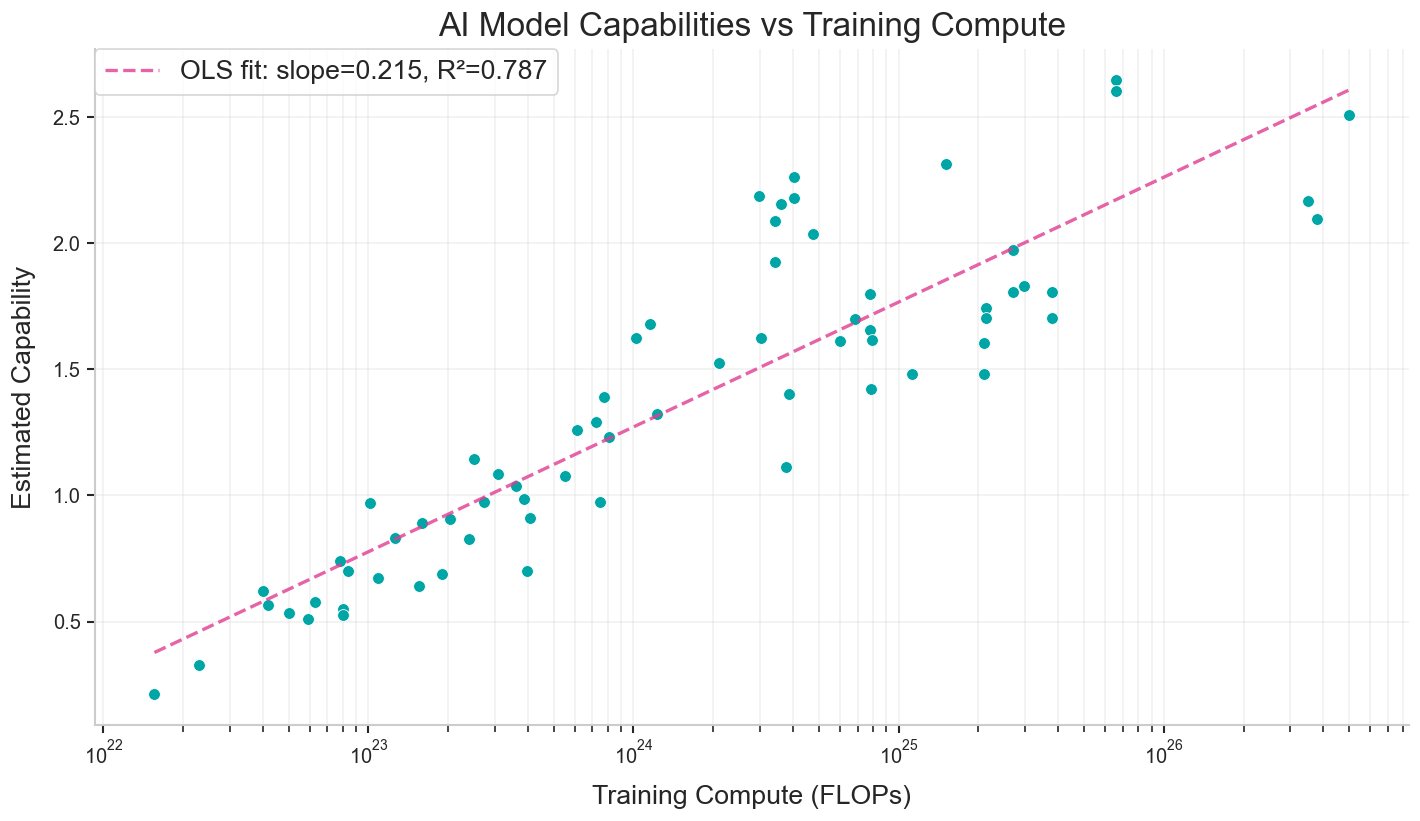

Number of models with compute data: 68
Compute range: [1.56e+22, 5.00e+26] FLOPs
Capability range: [0.213, 2.645]


In [8]:
# Simple plot: Capabilities vs Training Compute (log scale)
plt.figure(figsize=(12, 7))

# Filter to models with compute data
df_with_compute = df[df['compute'].notna()].copy()
df_with_compute['log_compute'] = np.log(df_with_compute['compute'])

# Create scatter plot with compute (not log_compute) on x-axis
plt.scatter(df_with_compute['compute'], 
           df_with_compute['estimated_capability'],  color=colors[0],
           alpha=1, s=50, edgecolors='white', linewidth=0.5)

plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Training Compute (FLOPs)', fontsize=16)
plt.ylabel('Estimated Capability', fontsize=16)
plt.title('AI Model Capabilities vs Training Compute', fontsize=20)
plt.grid(True, alpha=0.3, which='both')

# Add a simple OLS fit line (still fit in log space for linearity)
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    df_with_compute['log_compute'], 
    df_with_compute['estimated_capability']
)
# Create fit line in original compute space
compute_range = np.logspace(np.log10(df_with_compute['compute'].min()), 
                            np.log10(df_with_compute['compute'].max()), 100)
capability_fit = slope * np.log(compute_range) + intercept
plt.plot(compute_range, capability_fit, 
         '--', linewidth=2, alpha=0.8,  color=colors[1],
         label=f'OLS fit: slope={slope:.3f}, R²={r_value**2:.3f}')
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig("outputs/algorithmic_progress/capability_vs_log_compute.pdf", dpi=300, bbox_inches='tight')
plt.savefig("outputs/algorithmic_progress/capability_vs_log_compute.svg", format="svg")
# plt.savefig('outputs/figures/figure-7.svg', format='svg')

plt.show()

print(f"Number of models with compute data: {len(df_with_compute)}")
print(f"Compute range: [{df_with_compute['compute'].min():.2e}, {df_with_compute['compute'].max():.2e}] FLOPs")
print(f"Capability range: [{df_with_compute['estimated_capability'].min():.3f}, {df_with_compute['estimated_capability'].max():.3f}]")


# Table 2: Algorithmic progress (Section 3.2.2 Algorithmic progress)

Change this line to look at the frontier in capabilities or algorithmic quality: 

`k_sens_selection_mode = 'capability_frontier'      # 'all_models' | 'capability_frontier' | 'b_frontier'`

In [9]:
qwen_family = [
    # 'qwen-max-2025-01-25',
    'qwen2.5-72b-instruct',
    # 'qwen3-235b-a22b',
    # 'Qwen-14B',
    # 'Qwen-7B',
    'Qwen2.5-72B',
    'Qwen2.5-Coder-1.5B',
    'Qwen2.5-Coder-32B',
    'Qwen2.5-Coder-7B',
    'Qwen2.5-VL-72B-Instruct',
]

llama_family = [
    'LLaMA-13B',
    'LLaMA-33B',
    'LLaMA-65B',
    'LLaMA-7B',
]

llama2_family = [
    'Llama-2-13b',
    'Llama-2-34b',
    'Llama-2-70b-hf ',
    'Llama-2-7b',
]

llama3_1_family = [
    'Llama-3.1-405B',
    'Llama-3.1-405B-Instruct',
    'Llama-3.1-70B-Instruct',
    'Llama-3.1-8B-Instruct',
]

llama4_family = [
    'Llama-4-Maverick-17B-128E-Instruct',
    'Llama-4-Maverick-17B-128E-Instruct-FP8',
    'Llama-4-Scout-17B-16E-Instruct',
]

In [10]:
min_models = 3

all_families = {
    'Qwen': qwen_family,
    'LLaMA': llama_family,
    'LLaMA 2': llama2_family,
    'LLaMA 3.1': llama3_1_family,
}

# Check which families have sufficient data (>= 2 models with compute data)
valid_families = {}
family_stats = {}
for family_name, family_models in all_families.items():
    family_data = df[df['model'].isin(family_models) & df['compute'].notna()]
    if len(family_data) >= min_models:
        valid_families[family_name] = family_models
        family_stats[family_name] = {
            'count': len(family_data),
            'models': family_data['model'].tolist(),
            'compute_range': (family_data['compute'].min(), family_data['compute'].max()),
            'capability_range': (family_data['estimated_capability'].min(), family_data['estimated_capability'].max())
        }

print(f"Valid families with >= {min_models} models having compute data:")
for family_name, stats in family_stats.items():
    print(f"\n{family_name}: {stats['count']} models")
    print(f"  Models: {stats['models']}")
    print(f"  Compute range: {stats['compute_range'][0]:.2e} - {stats['compute_range'][1]:.2e} FLOPs")
    print(f"  Capability range: {stats['capability_range'][0]:.3f} - {stats['capability_range'][1]:.3f}")

print(f"\nTotal valid families: {len(valid_families)}")

Valid families with >= 3 models having compute data:

LLaMA: 4 models
  Models: ['LLaMA-65B', 'LLaMA-33B', 'LLaMA-13B', 'LLaMA-7B']
  Compute range: 4.00e+22 - 5.50e+23 FLOPs
  Capability range: 0.621 - 1.076

LLaMA 2: 4 models
  Models: ['Llama-2-70b-hf ', 'Llama-2-34b', 'Llama-2-13b', 'Llama-2-7b']
  Compute range: 8.40e+22 - 8.10e+23 FLOPs
  Capability range: 0.698 - 1.232

LLaMA 3.1: 4 models
  Models: ['Llama-3.1-405B', 'Llama-3.1-405B-Instruct', 'Llama-3.1-70B-Instruct', 'Llama-3.1-8B-Instruct']
  Compute range: 1.22e+24 - 3.80e+25 FLOPs
  Capability range: 1.320 - 1.806

Total valid families: 3


In [11]:
print("=" * 70)
print("TWO-STAGE APPROACH: ALGORITHMIC PROGRESS ANALYSIS")  
print("=" * 70)
print("\nSTAGE 1: Estimate k values per family (without temporal analysis)")
print("=" * 70)

# Step 1: For each family with sufficient data, estimate k only
family_k_estimates = {}

for family_name, family_models in all_families.items():
    family_data = df[df['model'].isin(family_models) & df['compute'].notna()].copy()
    
    if len(family_data) >= min_models:
        # Sort by date to see temporal progression
        family_data = family_data.sort_values('date')
        
        log_compute = np.log(family_data['compute'])
        capabilities = family_data['estimated_capability']
        
        # Check if we have sufficient variation in compute values
        if len(log_compute.unique()) > 1:
            # Fit family-specific k (compute scaling coefficient)
            slope_k, intercept, r_value, p_value, std_err = linregress(log_compute, capabilities)
            
            family_k_estimates[family_name] = {
                'family_k': slope_k,
                'k_r_squared': r_value**2,
                'k_std_err': std_err,
                'n_models': len(family_data),
                'date_range': (family_data['date'].min(), family_data['date'].max()),
                'data': family_data,
                'intercept': intercept
            }
            
            print(f"\n{family_name} Family:")
            print(f"  • Models: {len(family_data)} ({family_data['date'].min()} to {family_data['date'].max()})")
            print(f"  • Estimated k: {slope_k:.4f} ± {std_err:.4f} (R² = {r_value**2:.3f})")
            
            # Show the models in this family
            for idx, row in family_data.iterrows():
                print(f"    {row['date']} {row['model']:30s} C={row['estimated_capability']:.3f} F={row['compute']:.2e}")
            
        else:
            print(f"{family_name}: Insufficient compute variation (all models have same compute)")
    else:
        if len(family_data) > 0:
            print(f"{family_name}: Insufficient data ({len(family_data)} models with compute)")

print(f"\n\nSummary: Successfully estimated k for {len(family_k_estimates)} families")
print("=" * 70)

# Calculate average k across families
k_values = [results['family_k'] for results in family_k_estimates.values()]
k_weights = [results['n_models'] for results in family_k_estimates.values()]  # Weight by number of models

# Simple average
k_mean_simple = np.mean(k_values)
k_std_simple = np.std(k_values)

# Weighted average (by number of models in each family)
k_mean_weighted = np.average(k_values, weights=k_weights)

print(f"\nEstimated k values across families:")
for family_name, results in family_k_estimates.items():
    print(f"  {family_name:15s}: k = {results['family_k']:.4f} (n={results['n_models']})")

print(f"\nAverage k (simple): {k_mean_simple:.4f} ± {k_std_simple:.4f}")
print(f"Average k (weighted by n): {k_mean_weighted:.4f}")

# Use the weighted average going forward
k_fixed = k_mean_weighted
print(f"\n>>> USING FIXED k = {k_fixed:.4f} for Stage 2 <<<")

TWO-STAGE APPROACH: ALGORITHMIC PROGRESS ANALYSIS

STAGE 1: Estimate k values per family (without temporal analysis)
Qwen: Insufficient data (2 models with compute)

LLaMA Family:
  • Models: 4 (2023-02-24 to 2023-02-24)
  • Estimated k: 0.1760 ± 0.0055 (R² = 0.998)
    2023-02-24 LLaMA-65B                      C=1.076 F=5.50e+23
    2023-02-24 LLaMA-33B                      C=0.974 F=2.73e+23
    2023-02-24 LLaMA-13B                      C=0.740 F=7.80e+22
    2023-02-24 LLaMA-7B                       C=0.621 F=4.00e+22

LLaMA 2 Family:
  • Models: 4 (2023-07-18 to 2023-07-18)
  • Estimated k: 0.2049 ± 0.0585 (R² = 0.860)
    2023-07-18 Llama-2-70b-hf                 C=1.232 F=8.10e+23
    2023-07-18 Llama-2-34b                    C=0.911 F=4.08e+23
    2023-07-18 Llama-2-13b                    C=0.889 F=1.60e+23
    2023-07-18 Llama-2-7b                     C=0.698 F=8.40e+22

LLaMA 3.1 Family:
  • Models: 4 (2024-07-23 to 2024-07-23)
  • Estimated k: 0.1240 ± 0.0221 (R² = 0.940)
   

In [12]:
print("\n\n" + "=" * 70)
print("STAGE 2: Fit b values over time with fixed k")
print("=" * 70)

# Now use fixed k to calculate b for ALL models with compute data
all_models_with_compute = df[df['compute'].notna()].copy()
all_models_with_compute['log_compute'] = np.log(all_models_with_compute['compute'])
all_models_with_compute['date_numeric'] = (
    pd.to_datetime(all_models_with_compute['date']).dt.year + 
    pd.to_datetime(all_models_with_compute['date']).dt.dayofyear / 365.25
)

# Calculate b for each model using fixed k: b = C - k * ln(F)
all_models_with_compute['b'] = (
    all_models_with_compute['estimated_capability'] - 
    k_fixed * all_models_with_compute['log_compute']
)

print(f"\nUsing {len(all_models_with_compute)} models with compute data")
print(f"Date range: {all_models_with_compute['date'].min()} to {all_models_with_compute['date'].max()}")

# Fit temporal trend in b across all models
b_slope, b_intercept, b_r_value, b_p_value, b_std_err = linregress(
    all_models_with_compute['date_numeric'], 
    all_models_with_compute['b']
)

print(f"\nTemporal trend in b:")
print(f"  db/dt = {b_slope:.4f} ± {b_std_err:.4f} per year")
print(f"  R² = {b_r_value**2:.3f}")
print(f"  p-value = {b_p_value:.3e}")

# Calculate 95% CI for db/dt
n_obs = len(all_models_with_compute)
df_dof = max(1, n_obs - 2)
t95 = t.ppf(0.975, df=df_dof)  # 0.975 for two-tailed 95% CI
dbdt_95_lower = b_slope - t95 * b_std_err
dbdt_95_upper = b_slope + t95 * b_std_err

print(f"\n  95% CI for db/dt: [{dbdt_95_lower:.4f}, {dbdt_95_upper:.4f}] per year")

# Convert to algorithmic progress rate
# If C = k*ln(F) + b(t), and b(t) = b0 + (db/dt)*t
# Then to maintain same C, we need: k*ln(F2/F1) = -(db/dt)*Δt
# So F2/F1 = exp(-(db/dt)*Δt / k)
# For annual improvement: F_new/F_old = exp(-(db/dt) / k)

compute_ratio_per_year = np.exp(-b_slope / k_fixed)
efficiency_improvement_per_year = 1 / compute_ratio_per_year

# 90% CI for efficiency improvement via t-based CI on slope
t90 = t.ppf(0.95, df=df_dof)
_eff_low = np.exp((b_slope - t90 * b_std_err) / k_fixed)
_eff_high = np.exp((b_slope + t90 * b_std_err) / k_fixed)
eff_improve_90_lo, eff_improve_90_hi = _eff_low, _eff_high

# 95% CI for efficiency improvement
_eff_low_95 = np.exp((b_slope - t95 * b_std_err) / k_fixed)
_eff_high_95 = np.exp((b_slope + t95 * b_std_err) / k_fixed)
eff_improve_95_lo, eff_improve_95_hi = _eff_low_95, _eff_high_95

print(f"\nAlgorithmic Progress Interpretation:")
print(f"  • Annual efficiency improvement: {efficiency_improvement_per_year:.2f}× (90% CI: {eff_improve_90_lo:.2f}–{eff_improve_90_hi:.2f}×; 95% CI: {eff_improve_95_lo:.2f}–{eff_improve_95_hi:.2f}×)")
print(f"  • Halving time (2× efficiency): {np.log(2) / np.log(efficiency_improvement_per_year):.2f} years")



STAGE 2: Fit b values over time with fixed k

Using 68 models with compute data
Date range: 2023-02-24 to 2025-09-24

Temporal trend in b:
  db/dt = 0.2971 ± 0.0330 per year
  R² = 0.551
  p-value = 4.284e-13

  95% CI for db/dt: [0.2312, 0.3629] per year

Algorithmic Progress Interpretation:
  • Annual efficiency improvement: 5.84× (90% CI: 4.21–8.10×; 95% CI: 3.95–8.64×)
  • Halving time (2× efficiency): 0.39 years


In [13]:
# ============================================================================
# ALGORITHMIC PROGRESS WITH FAMILY-SPECIFIC K VALUES
# Using k estimates from each family, with configurable model selection:
#   1. Use family-specific k values (already estimated in cell 12)
#   2. For each family's k, compute b for models: b = C - k*ln(F)
#   3. Select subset: all_models | capability_frontier | b_frontier
#   4. Fit db/dt over time using the selected subset
#   5. Calculate algorithmic progress using that family's k and db/dt
# This shows the range of algorithmic progress estimates based on k uncertainty
# ============================================================================

# Configuration
k_sens_selection_mode = 'capability_frontier'      # 'all_models' | 'capability_frontier' | 'b_frontier'
k_sens_frontier_grouping = 'year'         # 'year' | 'month' | 'date' (for per-group mode)
k_sens_frontier_mode = 'record'           # 'record' (running record-high) | 'per_group' (top-N per period)
k_sens_n_top = 1                          # N for per_group selection

print("=" * 70)
print(f"ALGORITHMIC PROGRESS WITH FAMILY-SPECIFIC K VALUES")
print(f"Selection mode: {k_sens_selection_mode}")
print("=" * 70)

# Prepare all models data
all_models_for_k_sensitivity = df[df['compute'].notna()].copy()
all_models_for_k_sensitivity['log_compute'] = np.log(all_models_for_k_sensitivity['compute'])
all_models_for_k_sensitivity['date_obj'] = pd.to_datetime(all_models_for_k_sensitivity['date'])
all_models_for_k_sensitivity['date_numeric'] = (
    all_models_for_k_sensitivity['date_obj'].dt.year + 
    all_models_for_k_sensitivity['date_obj'].dt.dayofyear / 365.25
)

# Frontier grouping key (only needed for per_group mode)
if k_sens_frontier_grouping == 'year':
    all_models_for_k_sensitivity['frontier_group'] = all_models_for_k_sensitivity['date_obj'].dt.year
elif k_sens_frontier_grouping == 'month':
    all_models_for_k_sensitivity['frontier_group'] = all_models_for_k_sensitivity['date_obj'].dt.to_period('M').astype(str)
elif k_sens_frontier_grouping == 'date':
    all_models_for_k_sensitivity['frontier_group'] = all_models_for_k_sensitivity['date']
else:
    raise ValueError("k_sens_frontier_grouping must be 'year', 'month', or 'date'")

print(f"\nTotal models with compute data: {len(all_models_for_k_sensitivity)}")
print(f"Date range: {all_models_for_k_sensitivity['date'].min()} to {all_models_for_k_sensitivity['date'].max()}")

# For each family's k value, compute b for all models, select subset, and fit db/dt
k_sensitivity_results = []

for family_name, results in family_k_estimates.items():
    family_k = results['family_k']
    
    # Compute b for ALL models using this family's k
    all_models_for_k_sensitivity[f'b_{family_name}'] = (
        all_models_for_k_sensitivity['estimated_capability'] - 
        family_k * all_models_for_k_sensitivity['log_compute']
    )
    
    # Select subset based on selection_mode
    if k_sens_selection_mode == 'all_models':
        subset_df = all_models_for_k_sensitivity.copy()
        subset_label = 'All models'
    elif k_sens_selection_mode == 'capability_frontier':
        if k_sens_frontier_mode == 'per_group':
            subset_df = (
                all_models_for_k_sensitivity
                .groupby('frontier_group', group_keys=False)
                .apply(lambda x: x.nlargest(k_sens_n_top, 'estimated_capability'), include_groups=False)
                .reset_index(drop=True)
            )
            subset_label = f'Top-{k_sens_n_top} capability per {k_sens_frontier_grouping}'
        elif k_sens_frontier_mode == 'record':
            subset_df = all_models_for_k_sensitivity.sort_values('date_numeric').copy()
            subset_df['cummax_cap'] = subset_df['estimated_capability'].cummax()
            subset_df = subset_df[subset_df['estimated_capability'] >= subset_df['cummax_cap']].copy()
            subset_label = 'Capability record frontier'
        else:
            raise ValueError("k_sens_frontier_mode must be 'record' or 'per_group'")
    elif k_sens_selection_mode == 'b_frontier':
        if k_sens_frontier_mode == 'per_group':
            subset_df = (
                all_models_for_k_sensitivity
                .groupby('frontier_group', group_keys=False)
                .apply(lambda x: x.nlargest(k_sens_n_top, f'b_{family_name}'), include_groups=False)
                .reset_index(drop=True)
            )
            subset_label = f'Top-{k_sens_n_top} b per {k_sens_frontier_grouping}'
        elif k_sens_frontier_mode == 'record':
            subset_df = all_models_for_k_sensitivity.sort_values('date_numeric').copy()
            subset_df['cummax_b'] = subset_df[f'b_{family_name}'].cummax()
            subset_df = subset_df[subset_df[f'b_{family_name}'] >= subset_df['cummax_b']].copy()
            subset_label = 'b record frontier'
        else:
            raise ValueError("k_sens_frontier_mode must be 'record' or 'per_group'")
    else:
        raise ValueError("k_sens_selection_mode must be 'all_models', 'capability_frontier', or 'b_frontier'")
    
    # Fit temporal trend in b across the selected subset
    b_slope, b_intercept, b_r_value, b_p_value, b_std_err = linregress(
        subset_df['date_numeric'], 
        subset_df[f'b_{family_name}']
    )
    
    # Calculate algorithmic progress using this k
    compute_ratio_per_year = np.exp(-b_slope / family_k)
    efficiency_improvement_per_year = 1 / compute_ratio_per_year
    
    # Calculate 90% and 95% confidence intervals
    n_obs = len(subset_df)
    df_dof = max(1, n_obs - 2)
    
    # 90% CI
    t90 = t.ppf(0.95, df=df_dof)
    eff_low_90 = np.exp((b_slope - t90 * b_std_err) / family_k)
    eff_high_90 = np.exp((b_slope + t90 * b_std_err) / family_k)
    
    # 95% CI
    t95 = t.ppf(0.975, df=df_dof)
    dbdt_95_lower = b_slope - t95 * b_std_err
    dbdt_95_upper = b_slope + t95 * b_std_err
    eff_low_95 = np.exp((b_slope - t95 * b_std_err) / family_k)
    eff_high_95 = np.exp((b_slope + t95 * b_std_err) / family_k)
    
    k_sensitivity_results.append({
        'family': family_name,
        'k': family_k,
        'k_stderr': results['k_std_err'],
        'k_r_squared': results['k_r_squared'],
        'n_models_in_family': results['n_models'],
        'n_models_in_subset': n_obs,
        'subset_label': subset_label,
        'db_dt': b_slope,
        'db_dt_stderr': b_std_err,
        'db_dt_r_squared': b_r_value**2,
        'db_dt_p_value': b_p_value,
        'db_dt_95_ci_low': dbdt_95_lower,
        'db_dt_95_ci_high': dbdt_95_upper,
        'efficiency_improvement_per_year': efficiency_improvement_per_year,
        'efficiency_90_ci_low': eff_low_90,
        'efficiency_90_ci_high': eff_high_90,
        'efficiency_95_ci_low': eff_low_95,
        'efficiency_95_ci_high': eff_high_95,
        'compute_ratio_per_year': compute_ratio_per_year,
    })
    
    print(f"\n{family_name} Family k = {family_k:.4f} ({subset_label}, n={n_obs}):")
    print(f"  • db/dt: {b_slope:.4f} ± {b_std_err:.4f} per year (R² = {b_r_value**2:.3f}, p = {b_p_value:.3e})")
    print(f"  • 95% CI for db/dt: [{dbdt_95_lower:.4f}, {dbdt_95_upper:.4f}]")
    print(f"  • Efficiency improvement: {efficiency_improvement_per_year:.2f}× per year")
    print(f"    - 90% CI: [{eff_low_90:.2f}, {eff_high_90:.2f}]×")
    print(f"    - 95% CI: [{eff_low_95:.2f}, {eff_high_95:.2f}]×")
    print(f"  • Compute reduction: {compute_ratio_per_year:.3f}× per year")

k_sensitivity_df = pd.DataFrame(k_sensitivity_results)

if len(k_sensitivity_df) > 0:
    print("\n" + "=" * 70)
    print("SUMMARY: RANGE OF ALGORITHMIC PROGRESS ACROSS FAMILY K VALUES")
    print("=" * 70)
    
    print(f"\nNumber of family k values: {len(k_sensitivity_df)}")
    print(f"\nk value range: {k_sensitivity_df['k'].min():.4f} to {k_sensitivity_df['k'].max():.4f}")
    
    print(f"\nEfficiency improvement per year:")
    print(f"  • Range: {k_sensitivity_df['efficiency_improvement_per_year'].min():.2f}× to {k_sensitivity_df['efficiency_improvement_per_year'].max():.2f}×")
    print(f"  • Mean: {k_sensitivity_df['efficiency_improvement_per_year'].mean():.2f}×")
    print(f"  • Median: {k_sensitivity_df['efficiency_improvement_per_year'].median():.2f}×")
    print(f"  • Std Dev: {k_sensitivity_df['efficiency_improvement_per_year'].std():.2f}×")
    
    print(f"\ndb/dt per year:")
    print(f"  • Range: {k_sensitivity_df['db_dt'].min():.4f} to {k_sensitivity_df['db_dt'].max():.4f}")
    print(f"  • Mean: {k_sensitivity_df['db_dt'].mean():.4f}")
    print(f"  • Median: {k_sensitivity_df['db_dt'].median():.4f}")
    print(f"  • Std Dev: {k_sensitivity_df['db_dt'].std():.4f}")
    
    print(f"\nCompute reduction per year:")
    print(f"  • Range: {k_sensitivity_df['compute_ratio_per_year'].min():.3f}× to {k_sensitivity_df['compute_ratio_per_year'].max():.3f}×")
    print(f"  • Mean: {k_sensitivity_df['compute_ratio_per_year'].mean():.3f}×")
    print(f"  • Median: {k_sensitivity_df['compute_ratio_per_year'].median():.3f}×")
    
    # Summary table
    print(f"\n{'Family':<15} {'k':<10} {'n_subset':<10} {'db/dt':<12} {'Efficiency/yr':<15} {'90% CI Range':<30} {'95% CI Range':<30}")
    print("-" * 130)
    for _, row in k_sensitivity_df.iterrows():
        ci_range = f"[{row['efficiency_90_ci_low']:.2f}, {row['efficiency_90_ci_high']:.2f}]"
        ci_range_95 = f"[{row['efficiency_95_ci_low']:.2f}, {row['efficiency_95_ci_high']:.2f}]"
        print(f"{row['family']:<15} {row['k']:<10.4f} {row['n_models_in_subset']:<10} {row['db_dt']:<12.4f} {row['efficiency_improvement_per_year']:<15.2f} {ci_range:<30} {ci_range_95:<30}")
    
    print(f"\n{subset_label} (total n={len(all_models_for_k_sensitivity)})")
else:
    print("\nNo families had sufficient data for k sensitivity analysis")

print("\n" + "=" * 70)


ALGORITHMIC PROGRESS WITH FAMILY-SPECIFIC K VALUES
Selection mode: capability_frontier

Total models with compute data: 68
Date range: 2023-02-24 to 2025-09-24

LLaMA Family k = 0.1760 (Capability record frontier, n=11):
  • db/dt: 0.2958 ± 0.0793 per year (R² = 0.607, p = 4.691e-03)
  • 95% CI for db/dt: [0.1164, 0.4751]
  • Efficiency improvement: 5.37× per year
    - 90% CI: [2.35, 12.25]×
    - 95% CI: [1.94, 14.86]×
  • Compute reduction: 0.186× per year

LLaMA 2 Family k = 0.2049 (Capability record frontier, n=11):
  • db/dt: 0.2588 ± 0.0944 per year (R² = 0.455, p = 2.281e-02)
  • 95% CI for db/dt: [0.0452, 0.4723]
  • Efficiency improvement: 3.54× per year
    - 90% CI: [1.52, 8.23]×
    - 95% CI: [1.25, 10.02]×
  • Compute reduction: 0.283× per year

LLaMA 3.1 Family k = 0.1240 (Capability record frontier, n=11):
  • db/dt: 0.3625 ± 0.0570 per year (R² = 0.818, p = 1.304e-04)
  • 95% CI for db/dt: [0.2337, 0.4914]
  • Efficiency improvement: 18.60× per year
    - 90% CI: [8.02

UNIFIED FAMILY-k APPROACH: selection_mode=b_frontier
k_fixed_fam (family-weighted): 0.1683
Stage 2 selection: b record frontier
  • Subset size: 11 (of 68)
db/dt (subset): 0.3788 ± 0.0253 per year (R²=0.961, p=1.14e-07)
  95% CI for db/dt: [0.3216, 0.4360] per year
Efficiency improvement: 9.49× per year
  90% CI: [7.21, 12.50]×
  95% CI: [6.76, 13.33]×


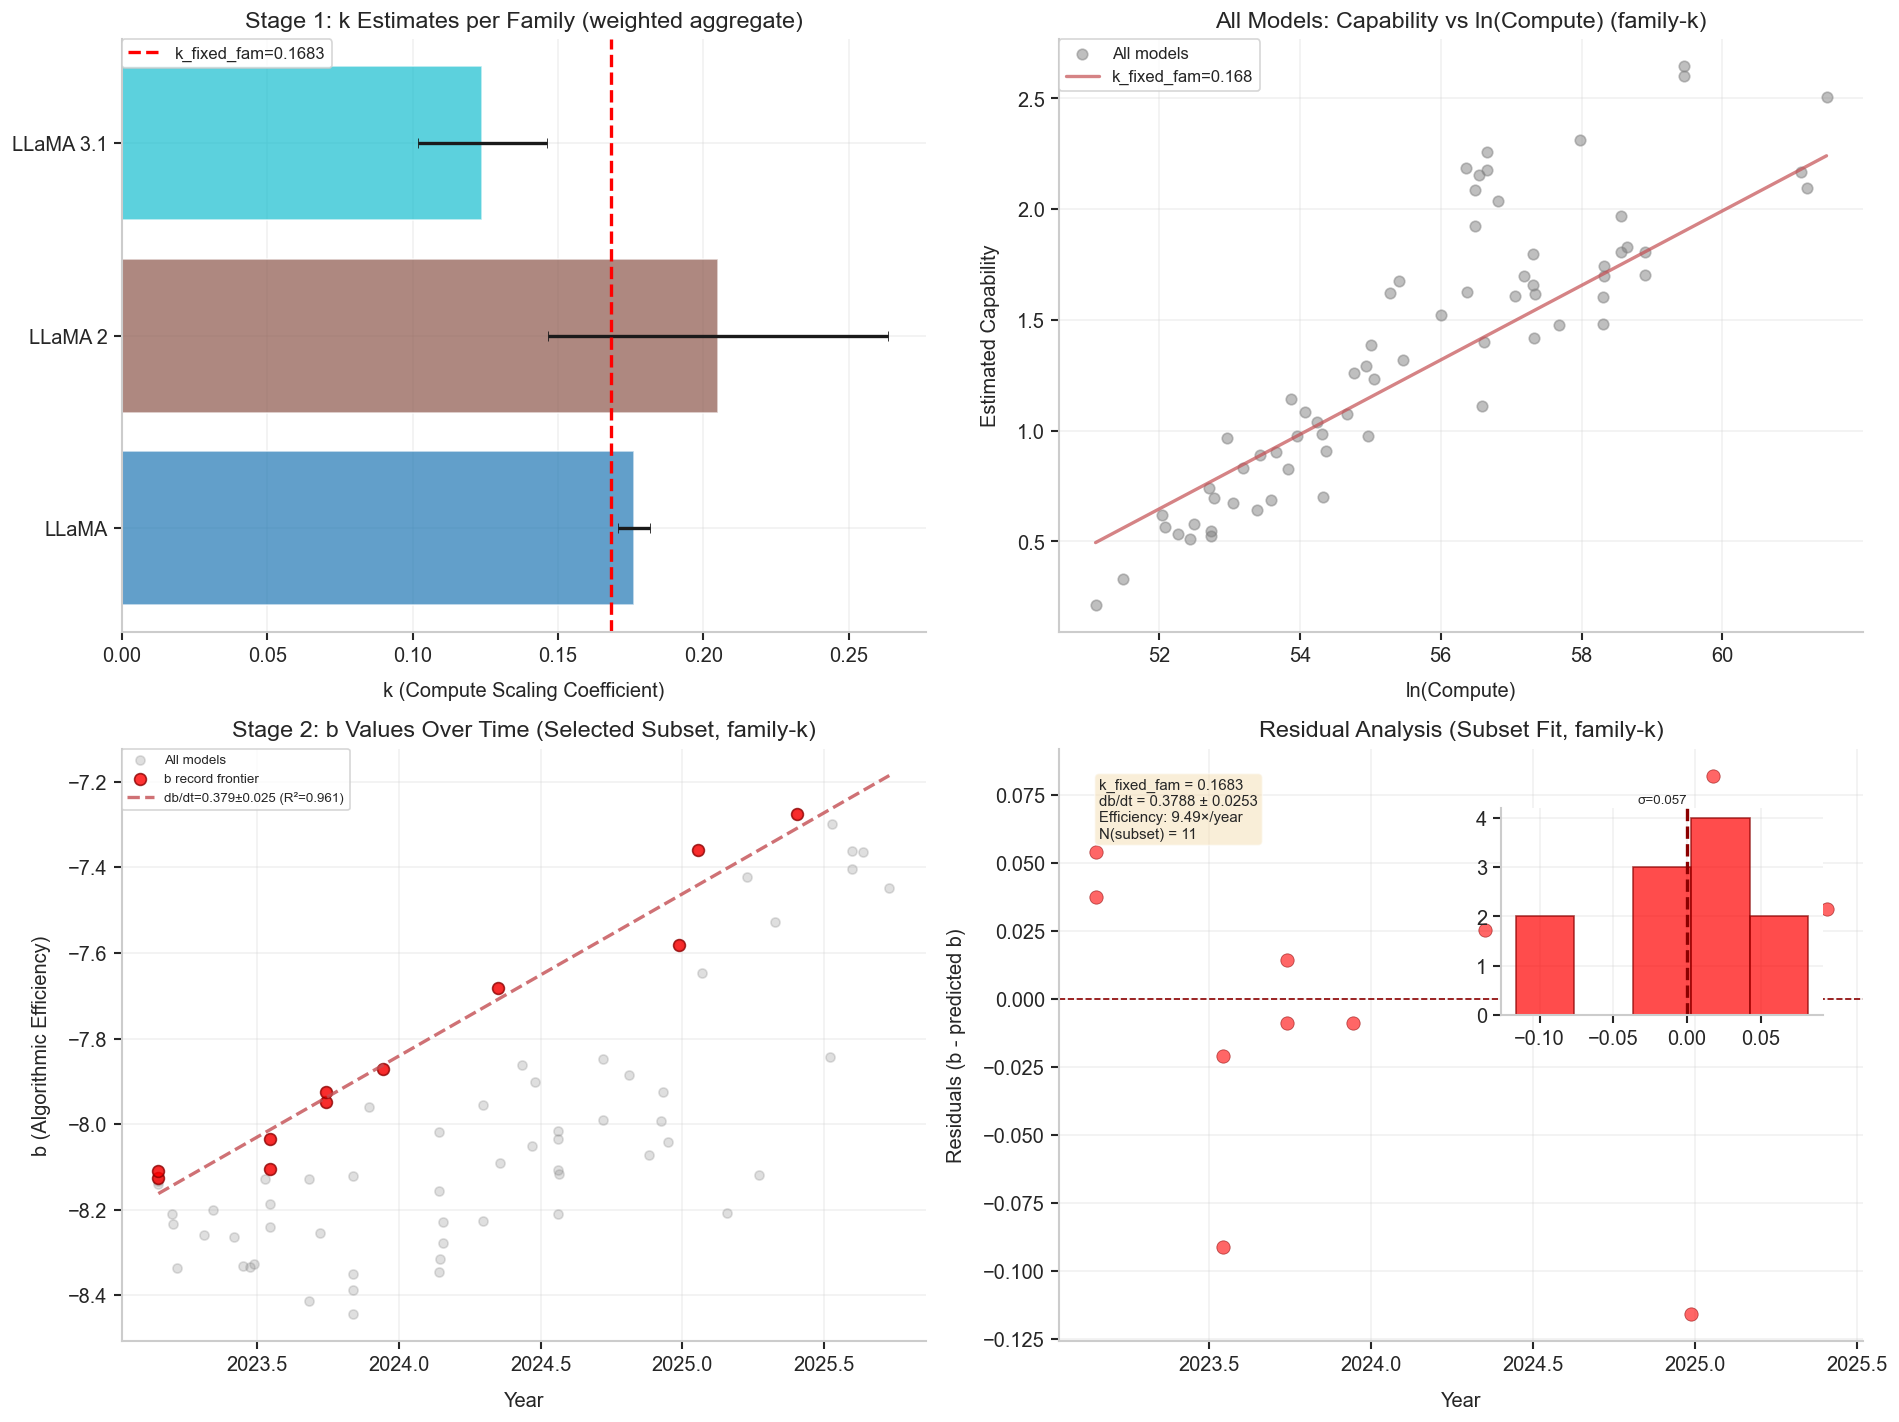

In [14]:
# ============================================================================
# Unified Family-k Approach — All Models vs Capability Frontier vs b Frontier
# - Stage 1: Estimate k per family; aggregate (weighted) to k_fixed_fam
# - Stage 2: Compute b for ALL models using k_fixed_fam, then choose subset:
#   * 'all_models': all models
#   * 'capability_frontier': frontier in estimated_capability (top-N or record)
#   * 'b_frontier': frontier in b (top-N or record)
# - Plots: Stage 1 family k overview + capability vs ln(compute),
#          Stage 2 b over time (subset), residuals, residual histogram
# ============================================================================

# Configuration
fam_selection_mode = 'b_frontier'      # 'all_models' | 'capability_frontier' | 'b_frontier'
fam_frontier_grouping = 'year'         # 'year' | 'month' | 'date' (for per-group mode)
fam_frontier_mode = 'record'           # 'record' (running record-high) | 'per_group' (top-N per period)
fam_n_top = 1                          # N for per_group selection
min_models_for_family = min_models if 'min_models' in globals() else 3

print("=" * 70)
print(f"UNIFIED FAMILY-k APPROACH: selection_mode={fam_selection_mode}")
print("=" * 70)

# ---------------------- Stage 1: Family-wise k ----------------------
# Ensure families and compute family-specific k if missing
if 'all_families' not in globals() or not isinstance(all_families, dict) or len(all_families) == 0:
    raise ValueError("all_families dict is not defined earlier in the notebook.")

family_k_estimates_local = {}
for family_name, family_models in all_families.items():
    fam_df = df[df['model'].isin(family_models) & df['compute'].notna()].copy()
    if len(fam_df) >= min_models_for_family:
        log_compute = np.log(fam_df['compute'])
        capabilities = fam_df['estimated_capability']
        if len(np.unique(log_compute)) > 1:
            slope_k, intercept, r_value, p_value, std_err = linregress(log_compute, capabilities)
            family_k_estimates_local[family_name] = {
                'family_k': slope_k,
                'k_r_squared': r_value**2,
                'k_std_err': std_err,
                'n_models': len(fam_df),
                'data': fam_df,
                'intercept': intercept
            }

if len(family_k_estimates_local) == 0:
    raise ValueError("No families with sufficient data for family-wise k estimation.")

k_values_fam = [res['family_k'] for res in family_k_estimates_local.values()]
k_weights_fam = [res['n_models'] for res in family_k_estimates_local.values()]
k_fixed_fam = np.average(k_values_fam, weights=k_weights_fam)
print(f"k_fixed_fam (family-weighted): {k_fixed_fam:.4f}")

# Prepare ALL models for Stage 2 using family k
fam_base_df = df[df['compute'].notna()].copy()
fam_base_df['log_compute'] = np.log(fam_base_df['compute'])
fam_base_df['date_obj'] = pd.to_datetime(fam_base_df['date'])
fam_base_df['date_numeric'] = (
    fam_base_df['date_obj'].dt.year + fam_base_df['date_obj'].dt.dayofyear / 365.25
)
fam_base_df['b'] = fam_base_df['estimated_capability'] - k_fixed_fam * fam_base_df['log_compute']

# Frontier grouping key (only needed for per_group mode)
if fam_frontier_grouping == 'year':
    fam_base_df['frontier_group'] = fam_base_df['date_obj'].dt.year
elif fam_frontier_grouping == 'month':
    fam_base_df['frontier_group'] = fam_base_df['date_obj'].dt.to_period('M').astype(str)
elif fam_frontier_grouping == 'date':
    fam_base_df['frontier_group'] = fam_base_df['date']
else:
    raise ValueError("fam_frontier_grouping must be 'year', 'month', or 'date'")

# ---------------------- Stage 2: Select subset ----------------------
if fam_selection_mode == 'all_models':
    fam_subset_df = fam_base_df.copy()
    fam_subset_label = 'All models'
elif fam_selection_mode == 'capability_frontier':
    if fam_frontier_mode == 'per_group':
        fam_subset_df = (
            fam_base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(fam_n_top, 'estimated_capability'), include_groups=False)
            .reset_index(drop=True)
        )
        fam_subset_label = f'Top-{fam_n_top} capability per {fam_frontier_grouping}'
    elif fam_frontier_mode == 'record':
        fam_subset_df = fam_base_df.sort_values('date_numeric').copy()
        fam_subset_df['cummax_cap'] = fam_subset_df['estimated_capability'].cummax()
        fam_subset_df = fam_subset_df[fam_subset_df['estimated_capability'] >= fam_subset_df['cummax_cap']].copy()
        fam_subset_label = 'Capability record frontier'
    else:
        raise ValueError("fam_frontier_mode must be 'record' or 'per_group'")
elif fam_selection_mode == 'b_frontier':
    if fam_frontier_mode == 'per_group':
        fam_subset_df = (
            fam_base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(fam_n_top, 'b'), include_groups=False)
            .reset_index(drop=True)
        )
        fam_subset_label = f'Top-{fam_n_top} b per {fam_frontier_grouping}'
    elif fam_frontier_mode == 'record':
        fam_subset_df = fam_base_df.sort_values('date_numeric').copy()
        fam_subset_df['cummax_b'] = fam_subset_df['b'].cummax()
        fam_subset_df = fam_subset_df[fam_subset_df['b'] >= fam_subset_df['cummax_b']].copy()
        fam_subset_label = 'b record frontier'
    else:
        raise ValueError("fam_frontier_mode must be 'record' or 'per_group'")
else:
    raise ValueError("fam_selection_mode must be 'all_models', 'capability_frontier', or 'b_frontier'")

print(f"Stage 2 selection: {fam_subset_label}")
print(f"  • Subset size: {len(fam_subset_df)} (of {len(fam_base_df)})")

# Fit db/dt on the selected subset
if len(fam_subset_df) >= 2:
    fam_b_slope, fam_b_int, fam_b_r, fam_b_p, fam_b_se = linregress(
        fam_subset_df['date_numeric'], fam_subset_df['b']
    )
    fam_compute_ratio_per_year = np.exp(-fam_b_slope / k_fixed_fam)
    fam_efficiency_improvement_per_year = 1 / fam_compute_ratio_per_year
    
    # Calculate confidence intervals
    _n_fam = len(fam_subset_df)
    _df_fam = max(1, _n_fam - 2)
    
    # 90% CI using t critical with df = n-2 for the subset
    _t90_fam = t.ppf(0.95, df=_df_fam)
    _fam_eff_lo_90 = np.exp((fam_b_slope - _t90_fam * fam_b_se) / k_fixed_fam)
    _fam_eff_hi_90 = np.exp((fam_b_slope + _t90_fam * fam_b_se) / k_fixed_fam)
    
    # 95% CI
    _t95_fam = t.ppf(0.975, df=_df_fam)
    fam_dbdt_95_lower = fam_b_slope - _t95_fam * fam_b_se
    fam_dbdt_95_upper = fam_b_slope + _t95_fam * fam_b_se
    _fam_eff_lo_95 = np.exp((fam_b_slope - _t95_fam * fam_b_se) / k_fixed_fam)
    _fam_eff_hi_95 = np.exp((fam_b_slope + _t95_fam * fam_b_se) / k_fixed_fam)
    
    print(f"db/dt (subset): {fam_b_slope:.4f} ± {fam_b_se:.4f} per year (R²={fam_b_r**2:.3f}, p={fam_b_p:.2e})")
    print(f"  95% CI for db/dt: [{fam_dbdt_95_lower:.4f}, {fam_dbdt_95_upper:.4f}] per year")
    print(f"Efficiency improvement: {fam_efficiency_improvement_per_year:.2f}× per year")
    print(f"  90% CI: [{_fam_eff_lo_90:.2f}, {_fam_eff_hi_90:.2f}]×")
    print(f"  95% CI: [{_fam_eff_lo_95:.2f}, {_fam_eff_hi_95:.2f}]×")
else:
    fam_b_slope = fam_b_int = fam_b_r = fam_b_p = fam_b_se = np.nan
    fam_efficiency_improvement_per_year = np.nan
    print("Not enough points to fit a trend (need at least 2)")

# ----------------------------- Visualization -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Stage 1 — k estimates per family (and aggregate)
ax1 = axes[0, 0]
family_names = list(family_k_estimates_local.keys())
k_vals = [family_k_estimates_local[fn]['family_k'] for fn in family_names]
k_errs = [family_k_estimates_local[fn]['k_std_err'] for fn in family_names]
colors = plt.cm.tab10(np.linspace(0, 1, len(family_names)))
ax1.barh(family_names, k_vals, xerr=k_errs, color=colors, alpha=0.7)
ax1.axvline(k_fixed_fam, color='red', linestyle='--', linewidth=2, label=f'k_fixed_fam={k_fixed_fam:.4f}')
ax1.set_xlabel('k (Compute Scaling Coefficient)')
ax1.set_title('Stage 1: k Estimates per Family (weighted aggregate)')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Stage 1 — Capability vs ln(Compute) for all models (family k line)
ax2 = axes[0, 1]
ax2.scatter(fam_base_df['log_compute'], fam_base_df['estimated_capability'], alpha=0.5, s=40, color='gray', label='All models')
log_compute_range = np.linspace(fam_base_df['log_compute'].min(), fam_base_df['log_compute'].max(), 100)
median_b_all = fam_base_df['b'].median()
cap_line = k_fixed_fam * log_compute_range + median_b_all
ax2.plot(log_compute_range, cap_line, 'r-', linewidth=2, alpha=0.7, label=f'k_fixed_fam={k_fixed_fam:.3f}')
ax2.set_xlabel('ln(Compute)')
ax2.set_ylabel('Estimated Capability')
ax2.set_title('All Models: Capability vs ln(Compute) (family-k)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Stage 2 — b over time (subset highlighted)
ax3 = axes[1, 0]
ax3.scatter(fam_base_df['date_numeric'], fam_base_df['b'], alpha=0.25, s=30, color='gray', label='All models')
ax3.scatter(fam_subset_df['date_numeric'], fam_subset_df['b'], alpha=0.8, s=50, color='red', edgecolors='darkred', linewidth=1, label=fam_subset_label)
if len(fam_subset_df) >= 2:
    tmin, tmax = fam_base_df['date_numeric'].min(), fam_base_df['date_numeric'].max()
    time_range = np.linspace(tmin, tmax, 100)
    ax3.plot(time_range, fam_b_slope * time_range + fam_b_int, 'r--', linewidth=2, alpha=0.8, label=f'db/dt={fam_b_slope:.3f}±{fam_b_se:.3f} (R²={fam_b_r**2:.3f})')
ax3.set_xlabel('Year')
ax3.set_ylabel('b (Algorithmic Efficiency)')
ax3.set_title('Stage 2: b Values Over Time (Selected Subset, family-k)')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals (subset fit)
ax4 = axes[1, 1]
if len(fam_subset_df) >= 2:
    fam_pred_b = fam_b_slope * fam_subset_df['date_numeric'] + fam_b_int
    fam_residuals = fam_subset_df['b'] - fam_pred_b
    ax4.scatter(fam_subset_df['date_numeric'], fam_residuals, alpha=0.6, color='red', edgecolors='darkred', linewidth=0.5)
    ax4.axhline(0, color='darkred', linestyle='--', linewidth=1)
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Residuals (b - predicted b)')
    ax4.set_title('Residual Analysis (Subset Fit, family-k)')
    textstr = (
        f'k_fixed_fam = {k_fixed_fam:.4f}\n'
        f'db/dt = {fam_b_slope:.4f} ± {fam_b_se:.4f}\n'
        f'Efficiency: {fam_efficiency_improvement_per_year:.2f}×/year\n'
        f'N(subset) = {len(fam_subset_df)}'
    )
    ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    # Residual histogram inset to keep layout consistent
    inset_ax = ax4.inset_axes([0.55, 0.55, 0.4, 0.35])
    inset_ax.hist(fam_residuals, bins=min(20, max(3, len(fam_residuals)//2)), alpha=0.7, color='red', edgecolor='darkred')
    inset_ax.axvline(0, color='darkred', linestyle='--', linewidth=2)
    inset_ax.set_title(f'σ={np.std(fam_residuals):.3f}', fontsize=8)
else:
    ax4.text(0.5, 0.5, 'Insufficient points for residuals', ha='center', va='center')
    ax4.set_axis_off()

plt.tight_layout()
plt.savefig("outputs/algorithmic_progress/algorithmic_progress_unified_family_k_approach.pdf", dpi=300, bbox_inches='tight')
plt.show()


# Algorithmic progress without holding the training recipe fixed (Appendix C.1.2 Estimating k using all models with training compute estimates)

UNIFIED APPROACH: selection_mode=capability_frontier
Stage 1 (all models): k = 0.2148 ± 0.0138 (R²=0.787)
Stage 2 selection: Capability record frontier
  • Subset size: 11 (of 68)
db/dt (subset): 0.2461 ± 0.0998 per year (R²=0.403, p=3.58e-02)
  95% CI for db/dt: [0.0203, 0.4719] per year
Efficiency improvement: 3.15× per year
  90% CI: [1.34, 7.37]×
  95% CI: [1.10, 9.00]×


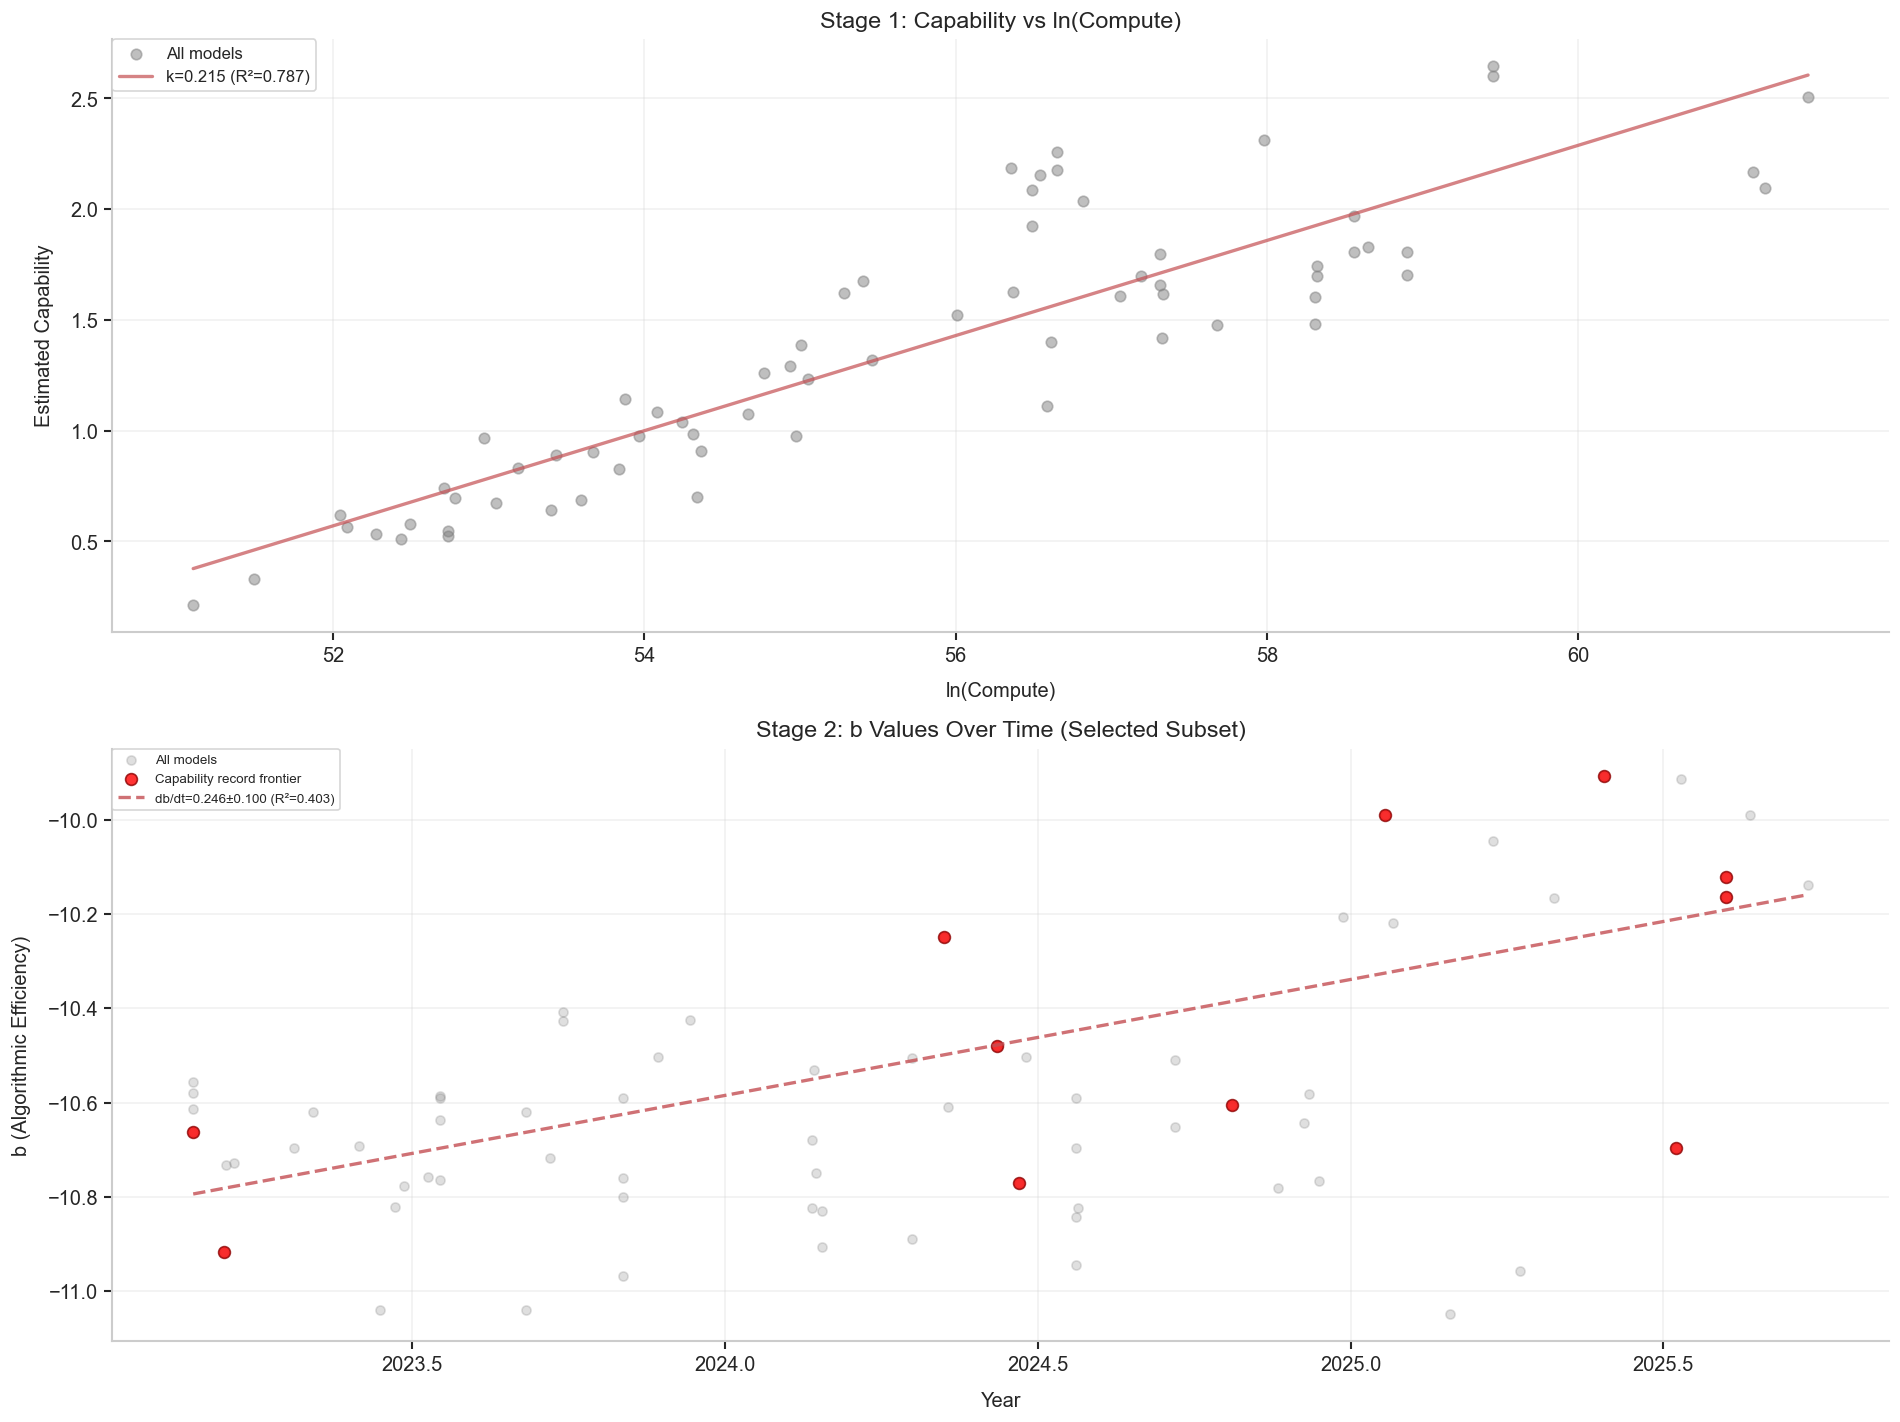

In [15]:
# ============================================================================
# Unified Approach Selector — All Models vs Capability Frontier vs b Frontier
# - Stage 1: Estimate k from all models (pooled)
# - Stage 2: Depending on selection_mode, fit db/dt using:
#   * 'all_models': all models
#   * 'capability_frontier': frontier in estimated_capability (top-N or record)
#   * 'b_frontier': frontier in b (top-N or record)
# - Plots: Stage 1 capability vs ln(compute), Stage 2 b over time, residuals, histogram
# ============================================================================

# Configuration
selection_mode = 'capability_frontier'       # 'all_models' | 'capability_frontier' | 'b_frontier'
frontier_grouping = 'year'          # 'year' | 'month' | 'date' (only used for frontier selection)
frontier_mode = 'record'            # 'record' (running record-high) | 'per_group' (top-N per period)
n_top = 1                           # N for per_group selection

print("=" * 70)
print(f"UNIFIED APPROACH: selection_mode={selection_mode}")
print("=" * 70)

# Prepare data
base_df = df[df['compute'].notna()].copy()
base_df['log_compute'] = np.log(base_df['compute'])
base_df['date_obj'] = pd.to_datetime(base_df['date'])
base_df['date_numeric'] = (
    base_df['date_obj'].dt.year + base_df['date_obj'].dt.dayofyear / 365.25
)

# Stage 1: Estimate k from all models (pooled)
k_all_slope, k_all_intercept, k_all_r, k_all_p, k_all_se = linregress(
    base_df['log_compute'], base_df['estimated_capability']
)
print(f"Stage 1 (all models): k = {k_all_slope:.4f} ± {k_all_se:.4f} (R²={k_all_r**2:.3f})")

# Compute b using all-models k
base_df['b'] = base_df['estimated_capability'] - k_all_slope * base_df['log_compute']

# Frontier selection helpers
if frontier_grouping == 'year':
    base_df['frontier_group'] = base_df['date_obj'].dt.year
elif frontier_grouping == 'month':
    base_df['frontier_group'] = base_df['date_obj'].dt.to_period('M').astype(str)
elif frontier_grouping == 'date':
    base_df['frontier_group'] = base_df['date']
else:
    raise ValueError("frontier_grouping must be 'year', 'month', or 'date'")

if selection_mode == 'all_models':
    subset_df = base_df.copy()
    subset_label = 'All models'
elif selection_mode == 'capability_frontier':
    if frontier_mode == 'per_group':
        subset_df = (
            base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(n_top, 'estimated_capability'), include_groups=False)
            .reset_index(drop=True)
        )
        subset_label = f'Top-{n_top} capability per {frontier_grouping}'
    elif frontier_mode == 'record':
        subset_df = base_df.sort_values('date_numeric').copy()
        subset_df['cummax_cap'] = subset_df['estimated_capability'].cummax()
        subset_df = subset_df[subset_df['estimated_capability'] >= subset_df['cummax_cap']].copy()
        subset_label = 'Capability record frontier'
    else:
        raise ValueError("frontier_mode must be 'record' or 'per_group'")
elif selection_mode == 'b_frontier':
    if frontier_mode == 'per_group':
        subset_df = (
            base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(n_top, 'b'), include_groups=False)
            .reset_index(drop=True)
        )
        subset_label = f'Top-{n_top} b per {frontier_grouping}'
    elif frontier_mode == 'record':
        subset_df = base_df.sort_values('date_numeric').copy()
        subset_df['cummax_b'] = subset_df['b'].cummax()
        subset_df = subset_df[subset_df['b'] >= subset_df['cummax_b']].copy()
        subset_label = 'b record frontier'
    else:
        raise ValueError("frontier_mode must be 'record' or 'per_group'")
else:
    raise ValueError("selection_mode must be 'all_models', 'capability_frontier', or 'b_frontier'")

print(f"Stage 2 selection: {subset_label}")
print(f"  • Subset size: {len(subset_df)} (of {len(base_df)})")

# Stage 2: Fit db/dt on the selected subset
if len(subset_df) >= 2:
    b_slope_sel, b_int_sel, b_r_sel, b_p_sel, b_se_sel = linregress(
        subset_df['date_numeric'], subset_df['b']
    )
    compute_ratio_per_year_sel = np.exp(-b_slope_sel / k_all_slope)
    efficiency_improvement_per_year_sel = 1 / compute_ratio_per_year_sel
    
    # Calculate confidence intervals
    _n_sel = len(subset_df)
    _df_sel = max(1, _n_sel - 2)
    
    # 90% CI using t critical with df = n-2
    _t90_sel = t.ppf(0.95, df=_df_sel)
    _eff_lo_sel_90 = np.exp((b_slope_sel - _t90_sel * b_se_sel) / k_all_slope)
    _eff_hi_sel_90 = np.exp((b_slope_sel + _t90_sel * b_se_sel) / k_all_slope)
    
    # 95% CI
    _t95_sel = t.ppf(0.975, df=_df_sel)
    dbdt_95_lower_sel = b_slope_sel - _t95_sel * b_se_sel
    dbdt_95_upper_sel = b_slope_sel + _t95_sel * b_se_sel
    _eff_lo_sel_95 = np.exp((b_slope_sel - _t95_sel * b_se_sel) / k_all_slope)
    _eff_hi_sel_95 = np.exp((b_slope_sel + _t95_sel * b_se_sel) / k_all_slope)
    
    print(f"db/dt (subset): {b_slope_sel:.4f} ± {b_se_sel:.4f} per year (R²={b_r_sel**2:.3f}, p={b_p_sel:.2e})")
    print(f"  95% CI for db/dt: [{dbdt_95_lower_sel:.4f}, {dbdt_95_upper_sel:.4f}] per year")
    print(f"Efficiency improvement: {efficiency_improvement_per_year_sel:.2f}× per year")
    print(f"  90% CI: [{_eff_lo_sel_90:.2f}, {_eff_hi_sel_90:.2f}]×")
    print(f"  95% CI: [{_eff_lo_sel_95:.2f}, {_eff_hi_sel_95:.2f}]×")
else:
    b_slope_sel = b_int_sel = b_r_sel = b_p_sel = b_se_sel = np.nan
    efficiency_improvement_per_year_sel = np.nan
    print("Not enough points to fit a trend (need at least 2)")

# Visualization (2x2)
fig, axes = plt.subplots(2, figsize=(16, 12))

# Plot 1: Stage 1 — Capability vs ln(Compute)
ax1 = axes[0]
ax1.scatter(base_df['log_compute'], base_df['estimated_capability'], alpha=0.5, s=40, c='gray', label='All models')
log_compute_range = np.linspace(base_df['log_compute'].min(), base_df['log_compute'].max(), 100)
capability_line = k_all_slope * log_compute_range + k_all_intercept
ax1.plot(log_compute_range, capability_line, 'r-', linewidth=2, alpha=0.7, label=f'k={k_all_slope:.3f} (R²={k_all_r**2:.3f})')
ax1.set_xlabel('ln(Compute)')
ax1.set_ylabel('Estimated Capability')
ax1.set_title('Stage 1: Capability vs ln(Compute)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Stage 2 — b over time (subset highlighted)
ax2 = axes[1]
ax2.scatter(base_df['date_numeric'], base_df['b'], alpha=0.25, s=30, color='gray', label='All models')
ax2.scatter(subset_df['date_numeric'], subset_df['b'], alpha=0.8, s=50, color='red', edgecolors='darkred', linewidth=1, label=subset_label)
if len(subset_df) >= 2:
    tmin, tmax = base_df['date_numeric'].min(), base_df['date_numeric'].max()
    time_range = np.linspace(tmin, tmax, 100)
    ax2.plot(time_range, b_slope_sel * time_range + b_int_sel, 'r--', linewidth=2, alpha=0.8, label=f'db/dt={b_slope_sel:.3f}±{b_se_sel:.3f} (R²={b_r_sel**2:.3f})')
ax2.set_xlabel('Year')
ax2.set_ylabel('b (Algorithmic Efficiency)')
ax2.set_title('Stage 2: b Values Over Time (Selected Subset)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/algorithmic_progress/algorithmic_progress_unified_approach.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# ============================================================================
# Enhanced Confidence Intervals with k Uncertainty Propagation
# ============================================================================

# 1. Calculate 95% CI for k
n_k = len(base_df)
df_k = max(1, n_k - 2)
t95_k = t.ppf(0.975, df=df_k)

k_95_lower = k_all_slope - t95_k * k_all_se
k_95_upper = k_all_slope + t95_k * k_all_se

print(f"\n{'='*70}")
print("CONFIDENCE INTERVALS WITH FULL UNCERTAINTY PROPAGATION")
print(f"{'='*70}")
print(f"\nStage 1 - k estimate:")
print(f"  k = {k_all_slope:.4f} ± {k_all_se:.4f}")
print(f"  95% CI for k: [{k_95_lower:.4f}, {k_95_upper:.4f}]")
print(f"  (n = {n_k}, df = {df_k})")

if len(subset_df) >= 2:
    # 2. Propagate both k and db/dt uncertainties to efficiency estimate
    # Efficiency = exp(db/dt / k)
    # Using delta method in log space: log(Efficiency) = db/dt / k
    
    # Variance of log(Efficiency) using first-order Taylor expansion:
    # Var(log(E)) ≈ (1/k)² * Var(db/dt) + (db/dt/k²)² * Var(k)
    # Assuming independence between k and db/dt (reasonable since from separate regressions)
    
    var_dbdt = b_se_sel**2
    var_k = k_all_se**2
    
    # Variance in log space
    var_log_efficiency = (1/k_all_slope)**2 * var_dbdt + (b_slope_sel/k_all_slope**2)**2 * var_k
    se_log_efficiency = np.sqrt(var_log_efficiency)
    
    # Degrees of freedom for combined estimate (using Welch-Satterthwaite approximation)
    # This is more conservative than just using one df
    df_combined = ((var_log_efficiency)**2 / 
                   (((1/k_all_slope)**4 * var_dbdt**2 / df_k) + 
                    ((b_slope_sel/k_all_slope**2)**4 * var_k**2 / _df_sel)))
    df_combined = max(1, int(df_combined))
    
    t95_combined = t.ppf(0.975, df=df_combined)
    t90_combined = t.ppf(0.95, df=df_combined)
    
    log_efficiency = b_slope_sel / k_all_slope
    
    # 95% CI with full uncertainty propagation
    log_eff_95_lower_full = log_efficiency - t95_combined * se_log_efficiency
    log_eff_95_upper_full = log_efficiency + t95_combined * se_log_efficiency
    eff_95_lower_full = np.exp(log_eff_95_lower_full)
    eff_95_upper_full = np.exp(log_eff_95_upper_full)
    
    # 90% CI with full uncertainty propagation
    log_eff_90_lower_full = log_efficiency - t90_combined * se_log_efficiency
    log_eff_90_upper_full = log_efficiency + t90_combined * se_log_efficiency
    eff_90_lower_full = np.exp(log_eff_90_lower_full)
    eff_90_upper_full = np.exp(log_eff_90_upper_full)
    
    print(f"\nStage 2 - db/dt estimate:")
    print(f"  db/dt = {b_slope_sel:.4f} ± {b_se_sel:.4f} per year")
    print(f"  95% CI for db/dt: [{dbdt_95_lower_sel:.4f}, {dbdt_95_upper_sel:.4f}]")
    print(f"  (n = {len(subset_df)}, df = {_df_sel})")
    
    print(f"\nEfficiency Improvement Estimates:")
    print(f"  Point estimate: {efficiency_improvement_per_year_sel:.2f}× per year")
    print(f"\n  OLD 95% CI (ignoring k uncertainty): [{_eff_lo_sel_95:.2f}, {_eff_hi_sel_95:.2f}]×")
    print(f"  NEW 95% CI (with k uncertainty):     [{eff_95_lower_full:.2f}, {eff_95_upper_full:.2f}]×")
    print(f"\n  OLD 90% CI (ignoring k uncertainty): [{_eff_lo_sel_90:.2f}, {_eff_hi_sel_90:.2f}]×")
    print(f"  NEW 90% CI (with k uncertainty):     [{eff_90_lower_full:.2f}, {eff_90_upper_full:.2f}]×")
    
    # Calculate the relative contribution of each uncertainty source
    contribution_dbdt = ((1/k_all_slope)**2 * var_dbdt) / var_log_efficiency * 100
    contribution_k = ((b_slope_sel/k_all_slope**2)**2 * var_k) / var_log_efficiency * 100
    
    print(f"\nUncertainty Contributions:")
    print(f"  From db/dt: {contribution_dbdt:.1f}%")
    print(f"  From k:     {contribution_k:.1f}%")
    print(f"  (Combined df: {df_combined})")
    
    # Width comparison
    old_width_95 = _eff_hi_sel_95 - _eff_lo_sel_95
    new_width_95 = eff_95_upper_full - eff_95_lower_full
    width_increase = (new_width_95 - old_width_95) / old_width_95 * 100
    
    print(f"\nCI Width Analysis (95%):")
    print(f"  Old CI width: {old_width_95:.2f}×")
    print(f"  New CI width: {new_width_95:.2f}×")
    print(f"  Increase: {width_increase:.1f}%")


CONFIDENCE INTERVALS WITH FULL UNCERTAINTY PROPAGATION

Stage 1 - k estimate:
  k = 0.2148 ± 0.0138
  95% CI for k: [0.1873, 0.2422]
  (n = 68, df = 66)

Stage 2 - db/dt estimate:
  db/dt = 0.2461 ± 0.0998 per year
  95% CI for db/dt: [0.0203, 0.4719]
  (n = 11, df = 9)

Efficiency Improvement Estimates:
  Point estimate: 3.15× per year

  OLD 95% CI (ignoring k uncertainty): [1.10, 9.00]×
  NEW 95% CI (with k uncertainty):     [1.23, 8.04]×

  OLD 90% CI (ignoring k uncertainty): [1.34, 7.37]×
  NEW 90% CI (with k uncertainty):     [1.44, 6.89]×

Uncertainty Contributions:
  From db/dt: 97.6%
  From k:     2.4%
  (Combined df: 69)

CI Width Analysis (95%):
  Old CI width: 7.90×
  New CI width: 6.81×
  Increase: -13.8%


# Table 6 (Appendix C.2 Directly estimating algorithmic progress)


In [17]:
# useful functions
# ------------------------------------------------------------------
# 0.  Data prep  ----------------------------------------------------
# df_alt = df_cap.copy()

# # make sure the columns we'll need exist and are typed correctly
# for col in ["estimated_capability", "date", "compute"]:
#     assert col in df_alt.columns, f"missing {col}"
# df_alt["date"] = pd.to_datetime(df_alt["date"])
# df_alt = df_alt.sort_values("date")

# ---------------------------------------------------------------
# 0.  Data prep  -------------------------------------------------
df_cap_alt = df_cap.copy() 
for col in ["estimated_capability", "date", "compute"]:
    assert col in df_cap_alt.columns, f"missing {col}"
df_cap_alt["date"] = pd.to_datetime(df_cap_alt["date"])
df_cap_alt = df_cap_alt.sort_values("date")

def later_lower_compute(
    row: pd.Series,
    df_level: pd.DataFrame,
    cap_tol_below: Union[int, float] = 0.1,
    cap_tol_above: Union[int, float] = 0.1,
) -> pd.DataFrame:
    """
    Return **all** models that are
      • released after ``row["date"]``,
      • use ≤ the same compute, and
      • have capability within ±``cap_tol`` of the current row.

    Parameters
    ----------
    cap_tol : float
        Half-width of the allowed capability band. Default 0.1 means we keep
        models whose capability lies in
        [row[cap_col] - 0.1, row[cap_col] + 0.1].

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    later_mask   = df_level["date"].gt(row["date"])
    compute_mask = df_level["compute"].le(row["compute"])

    lower_bound  = row["estimated_capability"] - cap_tol_below
    upper_bound  = row["estimated_capability"] + cap_tol_above
    cap_mask     = df_level["estimated_capability"].between(lower_bound, upper_bound, inclusive="both")


    later_matches = df_level.loc[later_mask & compute_mask & cap_mask]
    out = pd.concat([row.to_frame().T, later_matches]).sort_values("date")

    return out


In [18]:
# ------------------------------------------------------------
# Regression + numeric output
# ------------------------------------------------------------
def compute_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
) -> dict:
    """
    Fit  log10(compute) ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_log10              – slope in log10 units per year (should be < 0)
        factor_per_year          – 10**slope (e.g. 0.75 ⇒ 25 % drop/yr)
        pct_reduction_per_year   – (1-factor)*100
        intercept_log10, r_value, p_value, stderr
    """

    df = df_slice.copy()
    # ensure chronological order & datetime dtype
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # log-10 transform of compute
    y = np.log10(df[compute_col].astype(float))

    slope, intercept, r, p, se = linregress(years, y)

    factor_per_year        = 10 ** slope          # < 1 if slope negative
    pct_reduction_per_year = (1 - factor_per_year) * 100

    return {
        "slope_log10": slope,
        "intercept_log10": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
        "factor_per_year": 1/factor_per_year,
        "pct_reduction_per_year": pct_reduction_per_year,
    }


# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
def plot_compute_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of compute vs date (log-y) with best-fit line overlaid.
    """
    stats = compute_regression_stats(df_slice, date_col=date_col, compute_col=compute_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # X for plotting
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # Fitted line in *linear* compute space
    y_fit_log10 = stats["intercept_log10"] + stats["slope_log10"] * years
    y_fit       = 10 ** y_fit_log10

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[compute_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_yscale("log")
    ax.set_xlabel("Date")
    ax.set_ylabel("Training compute")
    ax.set_title(
        title
        or "Compute trend (≈ constant capability)\n"
           f"≈ {stats['pct_reduction_per_year']:.1f}% less compute per year"
    )
    ax.legend()
    plt.tight_layout()


In [19]:
def later_higher_capability(
    df_level: pd.DataFrame,
    *,
    compute_target: Union[int, float],
    date_from: Union[str, pd.Timestamp],
    compute_tol_below: Union[int, float] = 1.0,
    compute_tol_above: Union[int, float] = 1.0,
    # ―― choose *either* a relative improvement … ―――――――――――――――――――――――――――――
    compare_row: Optional[pd.Series] = None,
    # ―― … or an absolute capability floor (ignored if compare_row is given) ――
    cap_floor: Optional[Union[int, float]] = None,
) -> pd.DataFrame:
    """
    Return **all** models that
      • are released after *date_from*,
      • use ≈ the *compute_target* (|Δ| ≤ compute_tol), **and**
      • beat either:
          – compare_row["estimated_capability"] + min_cap_gain,   if *compare_row* is given, or
          – the absolute level *cap_floor*,                       otherwise.

    Parameters
    ----------
    compute_target : float
        The compute budget you want to hold (roughly) constant.
    compute_tol : float, default 0
        Half-width of the allowed compute band.
        e.g. 0.05 means keep models in [target-0.05, target+0.05].
        Use an absolute value; if you prefer relative %, multiply first.
    date_from : str | pd.Timestamp
        Cut-off date – only later releases are considered.
    compare_row : pd.Series, optional
        If provided we measure "higher capability" relative to this row.
        If omitted we fall back to *cap_floor* (must then be supplied).
    min_cap_gain : float, default 0.1
        The minimum improvement over *compare_row* we insist on.
    cap_floor : float, optional
        Absolute capability threshold if *compare_row* is None.

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    date_from = pd.to_datetime(date_from)

    # later in time ------------------------------------------------
    later_mask = df_level["date"].gt(date_from)

    # roughly equal compute ---------------------------------------
    lower_compute = compute_target / compute_tol_below
    upper_compute = compute_target * compute_tol_above
    compute_mask = df_level["compute"].between(lower_compute, upper_compute, inclusive="both")

    # capability strictly higher ----------------------------------
    if compare_row is not None:
        cap_threshold = compare_row["estimated_capability"]
    elif cap_floor is not None:
        cap_threshold = cap_floor
    else:
        raise ValueError("Supply either compare_row or cap_floor")

    cap_mask = df_level["estimated_capability"].gt(cap_threshold)

    # ----------------------------------------------------------------
    later_better = df_level.loc[later_mask & compute_mask & cap_mask]
    return later_better.sort_values("date")


In [20]:
# ------------------------------------------------------------
# 1 A.  Regression stats
# ------------------------------------------------------------
def capability_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
) -> dict:
    """
    Fit  capability ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_per_year            – capability units gained per year
        intercept, r_value, p_value, stderr
    """
    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    y = df[cap_col].astype(float)

    slope, intercept, r, p, se = linregress(years, y)

    return {
        "slope_per_year": slope,
        "intercept": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
    }

# ------------------------------------------------------------
# 1 B.  Plot capability trend
# ------------------------------------------------------------
def plot_capability_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of capability vs date (linear y) with best-fit line.
    """
    stats = capability_regression_stats(df_slice, date_col=date_col, cap_col=cap_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )
    y_fit = stats["intercept"] + stats["slope_per_year"] * years

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[cap_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_xlabel("Date")
    ax.set_ylabel("Estimated capability")
    ax.set_title(
        title
        or "Capability trend (≈ constant compute)\n"
           f"≈ {stats['slope_per_year']:.3f} capability units gained per year"
    )
    ax.legend()
    plt.tight_layout()


In [21]:
# ============================================================================
# Compute Reduction at Fixed Capability (SOTA-filtered, Frontier approach)
# For each narrow capability bucket:
#   1. Find models in that bucket
#   2. Filter to models that were SOTA in compute efficiency at release
#      (used less compute than any prior model in that bucket)
#   3. Fit log10(compute) vs time linearly
#   4. Slope gives OOMs/year compute reduction
# ============================================================================

# Configuration
capability_bucket_width = 0.3  # Width of capability buckets
capability_bucket_stride = 0.1 #capability_bucket_width #0.2  # Stride between bucket starts (< width for overlap)
min_models_for_compute_fit = 3  # Minimum SOTA models needed per bucket

print("=" * 70)
print("COMPUTE REDUCTION AT FIXED CAPABILITY (SOTA-filtered)")
print("=" * 70)
print(f"Capability bucket width: {capability_bucket_width}")
print(f"Capability bucket stride: {capability_bucket_stride}")
print(f"Overlap: {'Yes' if capability_bucket_stride < capability_bucket_width else 'No'}")
print(f"Min SOTA models per bucket: {min_models_for_compute_fit}")

# Prepare data
df_compute_sota = df_cap_alt.copy()
df_compute_sota = df_compute_sota[df_compute_sota['compute'].notna()].copy()
df_compute_sota['date'] = pd.to_datetime(df_compute_sota['date'])
df_compute_sota = df_compute_sota.sort_values('date')

# Define capability buckets with optional overlap
cap_min = df_compute_sota['estimated_capability'].min()
cap_max = df_compute_sota['estimated_capability'].max()

# Create bucket start points with stride
bucket_starts = np.arange(
    np.floor(cap_min / capability_bucket_stride) * capability_bucket_stride,
    cap_max,
    capability_bucket_stride
)
# Each bucket extends from start to start + width
capability_buckets = [(start, start + capability_bucket_width) for start in bucket_starts 
                      if start + capability_bucket_width <= cap_max + capability_bucket_width]

print(f"\nCapability range: [{cap_min:.2f}, {cap_max:.2f}]")
print(f"Number of capability buckets: {len(capability_buckets)}")

# Analyze each capability bucket
compute_reduction_results = []

for bucket_lower, bucket_upper in capability_buckets:
    bucket_center = (bucket_lower + bucket_upper) / 2
    
    # Find models in this capability bucket
    in_bucket = df_compute_sota[
        (df_compute_sota['estimated_capability'] >= bucket_lower) &
        (df_compute_sota['estimated_capability'] < bucket_upper)
    ].copy()
    
    if len(in_bucket) < min_models_for_compute_fit:
        continue
    
    # Sort by date
    in_bucket = in_bucket.sort_values('date')
    
    # Filter to SOTA in compute efficiency at release
    # A model is SOTA if it uses less compute than all previous models in this bucket
    in_bucket['cummin_compute'] = in_bucket['compute'].cummin()
    sota_models = in_bucket[in_bucket['compute'] <= in_bucket['cummin_compute']].copy()
    
    if len(sota_models) < min_models_for_compute_fit:
        continue
    
    # Linear fit of log10(compute) vs time
    sota_models['date_numeric'] = (
        (sota_models['date'] - sota_models['date'].min()).dt.total_seconds() / (365.25 * 24 * 3600)
    )
    sota_models['log10_compute'] = np.log10(sota_models['compute'])
    
    try:
        slope, intercept, r_value, p_value, std_err = linregress(
            sota_models['date_numeric'],
            sota_models['log10_compute']
        )
        
        compute_reduction_results.append({
            'bucket_lower': bucket_lower,
            'bucket_upper': bucket_upper,
            'bucket_center': bucket_center,
            'n_models_total': len(in_bucket),
            'n_sota_models': len(sota_models),
            'date_range_years': (sota_models['date'].max() - sota_models['date'].min()).days / 365.25,
            'slope_ooms_per_year': slope,  # Negative means compute is decreasing
            'compute_reduction_ooms_per_year': -slope,  # Positive means reduction
            'compute_reduction_per_year': 10**(-slope),
            'intercept': intercept,
            'r_value': r_value,
            'r_squared': r_value**2,
            'p_value': p_value,
            'std_err': std_err
        })
    except Exception as e:
        print(f"Error processing capability bucket [{bucket_lower:.2f}, {bucket_upper:.2f}): {e}")
        continue

compute_reduction_df = pd.DataFrame(compute_reduction_results)

# Filter to buckets with minimum date range
min_date_range_years = 0.25
compute_reduction_df = compute_reduction_df[compute_reduction_df['date_range_years'] >= min_date_range_years].reset_index(drop=True)

print(f"\nCapability buckets with sufficient SOTA models: {len(compute_reduction_df)}")
if len(compute_reduction_df) > 0:
    print("\nCompute Reduction Results (SOTA-filtered):")
    print(compute_reduction_df[['bucket_lower', 'bucket_upper', 'n_models_total', 'n_sota_models',
                                 'date_range_years', 'compute_reduction_ooms_per_year', 'compute_reduction_per_year',
                                 'r_squared']].to_string(index=False))
    
    # Calculate summary statistics (only for buckets with negative slope, i.e., decreasing compute)
    valid_reductions = compute_reduction_df[compute_reduction_df['compute_reduction_ooms_per_year'] > 0]
    
    if len(valid_reductions) > 0:
        # Remove duplicate fits (same up to 5 significant figures)
        def round_to_n_sf(x, n=5):
            """Round to n significant figures"""
            if x == 0:
                return 0
            from math import log10, floor
            return round(x, -int(floor(log10(abs(x)))) + (n - 1))
        
        valid_reductions_copy = valid_reductions.copy()
        valid_reductions_copy['compute_reduction_rounded'] = valid_reductions_copy['compute_reduction_ooms_per_year'].apply(
            lambda x: round_to_n_sf(x, 5)
        )
        
        # Remove duplicates based on rounded values
        unique_reductions = valid_reductions_copy.drop_duplicates(subset=['compute_reduction_rounded'])
        
        # Calculate statistics on deduplicated data
        mean_reduction = unique_reductions['compute_reduction_ooms_per_year'].mean()
        median_reduction = unique_reductions['compute_reduction_ooms_per_year'].median()
        
        print(f"\n{'='*70}")
        print(f"SUMMARY STATISTICS (After removing duplicate fits)")
        print(f"{'='*70}")
        print(f"Mean compute reduction: {mean_reduction:.3f} OOMs/year")
        print(f"Median compute reduction: {median_reduction:.3f} OOMs/year")
        print(f"Range: {unique_reductions['compute_reduction_ooms_per_year'].min():.3f} to "
              f"{unique_reductions['compute_reduction_ooms_per_year'].max():.3f} OOMs/year")
        print(f"Number of unique buckets: {len(unique_reductions)} (removed {len(valid_reductions) - len(unique_reductions)} duplicates)")
        print(f"Total buckets with decreasing compute: {len(valid_reductions)} of {len(compute_reduction_df)}")
    else:
        print("\nNo buckets showed decreasing compute over time")
else:
    print("No capability buckets had sufficient data for analysis")


COMPUTE REDUCTION AT FIXED CAPABILITY (SOTA-filtered)
Capability bucket width: 0.3
Capability bucket stride: 0.1
Overlap: Yes
Min SOTA models per bucket: 3

Capability range: [0.21, 2.65]
Number of capability buckets: 25

Capability buckets with sufficient SOTA models: 10

Compute Reduction Results (SOTA-filtered):
 bucket_lower  bucket_upper  n_models_total  n_sota_models  date_range_years  compute_reduction_ooms_per_year  compute_reduction_per_year  r_squared
          0.8           1.1              12              4          0.591376                         0.683070                    4.820257   0.977595
          0.9           1.2              11              3          0.591376                         0.538159                    3.452701   0.623958
          1.2           1.5               9              4          0.443532                         2.616336                  413.367035   0.531760
          1.3           1.6               7              3          0.495551           

In [22]:
# ============================================================================
# Hyperparameter Search: Test different bucket configurations
# ============================================================================

import itertools
from math import log10, floor

def round_to_n_sf(x, n=5):
    """Round to n significant figures"""
    if x == 0:
        return 0
    return round(x, -int(floor(log10(abs(x)))) + (n - 1))

# Define hyperparameter ranges
widths = [0.2, 0.3, 0.4, 0.5]
strides = [0.1, 0.2, 0.3]
min_models_list = [3, 4, 5]

# Store results
hyperparam_results = []

print("=" * 90)
print("HYPERPARAMETER SEARCH: Compute Reduction at Fixed Capability")
print("=" * 90)
print(f"Testing {len(widths)} widths × {len(strides)} strides × {len(min_models_list)} min_models = {len(widths)*len(strides)*len(min_models_list)} combinations")
print()

# Loop through all combinations
for width, stride, min_models in itertools.product(widths, strides, min_models_list):
    # Skip invalid combinations (stride shouldn't be larger than width)
    if stride > width:
        continue
    
    # Prepare data
    df_compute_sota_hp = df_cap_alt.copy()
    df_compute_sota_hp = df_compute_sota_hp[df_compute_sota_hp['compute'].notna()].copy()
    df_compute_sota_hp['date'] = pd.to_datetime(df_compute_sota_hp['date'])
    df_compute_sota_hp = df_compute_sota_hp.sort_values('date')
    
    # Define capability buckets
    cap_min = df_compute_sota_hp['estimated_capability'].min()
    cap_max = df_compute_sota_hp['estimated_capability'].max()
    
    bucket_starts = np.arange(
        np.floor(cap_min / stride) * stride,
        cap_max,
        stride
    )
    capability_buckets = [(start, start + width) for start in bucket_starts 
                          if start + width <= cap_max + width]
    
    # Analyze each capability bucket
    compute_reduction_results = []
    
    for bucket_lower, bucket_upper in capability_buckets:
        # Find models in this capability bucket
        in_bucket = df_compute_sota_hp[
            (df_compute_sota_hp['estimated_capability'] >= bucket_lower) &
            (df_compute_sota_hp['estimated_capability'] < bucket_upper)
        ].copy()
        
        if len(in_bucket) < min_models:
            continue
        
        # Sort by date
        in_bucket = in_bucket.sort_values('date')
        
        # Filter to SOTA in compute efficiency at release
        in_bucket['cummin_compute'] = in_bucket['compute'].cummin()
        sota_models = in_bucket[in_bucket['compute'] <= in_bucket['cummin_compute']].copy()
        
        if len(sota_models) < min_models:
            continue
        
        # Linear fit of log10(compute) vs time
        sota_models['date_numeric'] = (
            (sota_models['date'] - sota_models['date'].min()).dt.total_seconds() / (365.25 * 24 * 3600)
        )
        sota_models['log10_compute'] = np.log10(sota_models['compute'])
        
        try:
            slope, intercept, r_value, p_value, std_err = linregress(
                sota_models['date_numeric'],
                sota_models['log10_compute']
            )
            
            compute_reduction_results.append({
                'compute_reduction_ooms_per_year': -slope
            })
        except:
            continue
    
    if len(compute_reduction_results) == 0:
        continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(compute_reduction_results)
    
    # Filter to positive reductions
    valid_reductions = results_df[results_df['compute_reduction_ooms_per_year'] > 0]
    
    if len(valid_reductions) == 0:
        continue
    
    # Calculate statistics
    mean_all = valid_reductions['compute_reduction_ooms_per_year'].mean()
    median_all = valid_reductions['compute_reduction_ooms_per_year'].median()
    min_all = valid_reductions['compute_reduction_ooms_per_year'].min()
    max_all = valid_reductions['compute_reduction_ooms_per_year'].max()
    n_buckets = len(valid_reductions)
    
    # Remove duplicates (same up to 5 sf)
    valid_reductions_copy = valid_reductions.copy()
    valid_reductions_copy['rounded'] = valid_reductions_copy['compute_reduction_ooms_per_year'].apply(
        lambda x: round_to_n_sf(x, 5)
    )
    unique_reductions = valid_reductions_copy.drop_duplicates(subset=['rounded'])
    
    mean_unique = unique_reductions['compute_reduction_ooms_per_year'].mean()
    median_unique = unique_reductions['compute_reduction_ooms_per_year'].median()
    min_unique = unique_reductions['compute_reduction_ooms_per_year'].min()
    max_unique = unique_reductions['compute_reduction_ooms_per_year'].max()
    n_unique = len(unique_reductions)
    n_duplicates = n_buckets - n_unique
    
    # Store results
    hyperparam_results.append({
        'width': width,
        'stride': stride,
        'min_models': min_models,
        'n_buckets': n_buckets,
        'n_unique': n_unique,
        'n_duplicates': n_duplicates,
        'mean_all': mean_all,
        'median_all': median_all,
        'min_all': min_all,
        'max_all': max_all,
        'range_all': max_all - min_all,
        'mean_unique': mean_unique,
        'median_unique': median_unique,
        'min_unique': min_unique,
        'max_unique': max_unique,
        'range_unique': max_unique - min_unique
    })

# Convert to DataFrame for easy viewing
hyperparam_df = pd.DataFrame(hyperparam_results)

print(f"Tested {len(hyperparam_df)} valid combinations\n")
print("=" * 90)
print("RESULTS SUMMARY")
print("=" * 90)
print()

# Display with all results
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

print("All buckets (before duplicate removal):")
print(hyperparam_df[['width', 'stride', 'min_models', 'n_buckets', 
                     'mean_all', 'median_all', 'min_all', 'max_all', 'range_all']].to_string(index=False))

print("\n" + "=" * 90)
print("After removing duplicates (same up to 5 significant figures):")
print(hyperparam_df[['width', 'stride', 'min_models', 'n_unique', 'n_duplicates',
                     'mean_unique', 'median_unique', 'min_unique', 'max_unique', 'range_unique']].to_string(index=False))

print("\n" + "=" * 90)
print("SUMMARY STATISTICS ACROSS ALL HYPERPARAMETER COMBINATIONS")
print("=" * 90)
print(f"\nBefore duplicate removal:")
print(f"  Mean reduction range: [{hyperparam_df['mean_all'].min():.3f}, {hyperparam_df['mean_all'].max():.3f}] OOMs/year")
print(f"  Median reduction range: [{hyperparam_df['median_all'].min():.3f}, {hyperparam_df['median_all'].max():.3f}] OOMs/year")
print(f"  Overall mean: {hyperparam_df['mean_all'].mean():.3f} ± {hyperparam_df['mean_all'].std():.3f} OOMs/year")
print(f"  Overall median: {hyperparam_df['median_all'].median():.3f} OOMs/year")

print(f"\nAfter duplicate removal:")
print(f"  Mean reduction range: [{hyperparam_df['mean_unique'].min():.3f}, {hyperparam_df['mean_unique'].max():.3f}] OOMs/year")
print(f"  Median reduction range: [{hyperparam_df['median_unique'].min():.3f}, {hyperparam_df['median_unique'].max():.3f}] OOMs/year")
print(f"  Overall mean: {hyperparam_df['mean_unique'].mean():.3f} ± {hyperparam_df['mean_unique'].std():.3f} OOMs/year")
print(f"  Overall median: {hyperparam_df['median_unique'].median():.3f} OOMs/year")

print(f"\nDuplicate statistics:")
print(f"  Average duplicates per configuration: {hyperparam_df['n_duplicates'].mean():.1f}")
print(f"  Max duplicates in any configuration: {hyperparam_df['n_duplicates'].max()}")
print(f"  Configurations with duplicates: {(hyperparam_df['n_duplicates'] > 0).sum()} / {len(hyperparam_df)}")


HYPERPARAMETER SEARCH: Compute Reduction at Fixed Capability
Testing 4 widths × 3 strides × 3 min_models = 36 combinations

Tested 29 valid combinations

RESULTS SUMMARY

All buckets (before duplicate removal):
 width  stride  min_models  n_buckets  mean_all  median_all  min_all   max_all  range_all
   0.2     0.1           3         10  2.085148    1.034255 0.215121 11.076220  10.861099
   0.2     0.1           4          2  1.034255    1.034255 0.683070  1.385439   0.702369
   0.2     0.2           3          4  0.783035    0.679018 0.266690  1.507414   1.240724
   0.2     0.2           4          1  0.683070    0.683070 0.683070  0.683070   0.000000
   0.3     0.1           3         12  2.846345    1.268289 0.215121 11.076220  10.861099
   0.3     0.1           4          6  1.417074    1.268289 0.683070  2.616336   1.933266
   0.3     0.1           5          1  1.574430    1.574430 1.574430  1.574430   0.000000
   0.3     0.2           3          6  2.863149    1.268289 0.266690 

# Figure 12a (Appendix C.2 Directly estimating algorithmic progress)


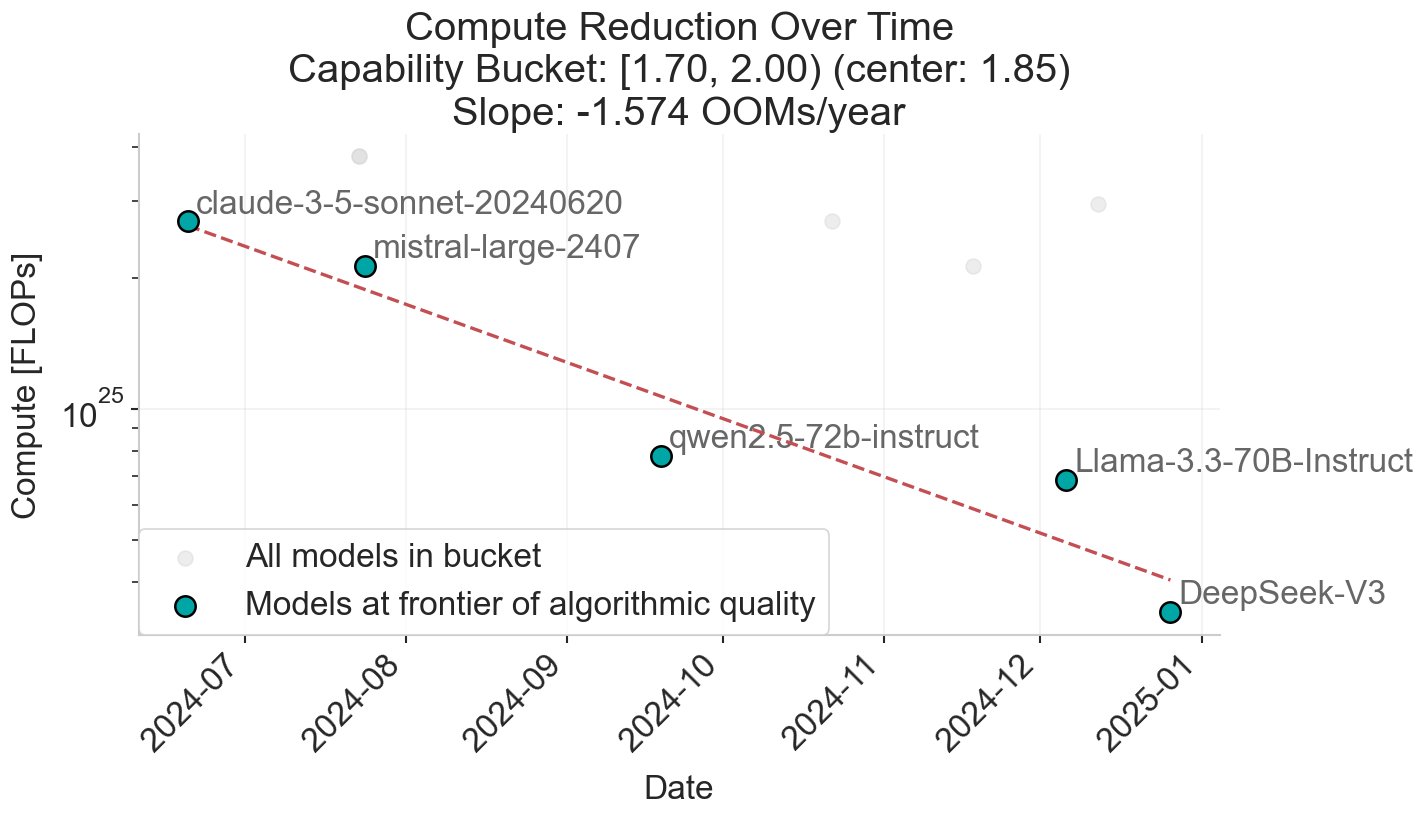


Bucket: [1.70, 2.00)
Total models: 10
SOTA models: 5
Date range: 2024-06-20 to 2024-12-26
Compute reduction: 1.574 OOMs/year
R²: 0.913
p-value: 1.119e-02


In [39]:
# ============================================================================
# Visual Plot: Compute vs Time for a Specific Capability Bucket
# ============================================================================

# SPECIFY WHICH BUCKET TO PLOT HERE:
# Options: use bucket indices from the summary table above, or specify range directly
selected_bucket_lower = 1.7  # Change this to select different bucket
selected_bucket_upper = 2.0  # Change this to select different bucket

import matplotlib.pyplot as plt
from scipy.stats import linregress

# Find models in the selected capability bucket
in_bucket = df_compute_sota[
    (df_compute_sota['estimated_capability'] >= selected_bucket_lower) &
    (df_compute_sota['estimated_capability'] < selected_bucket_upper)
].copy()

if len(in_bucket) < min_models_for_compute_fit:
    print(f"Not enough models in bucket [{selected_bucket_lower}, {selected_bucket_upper})")
    print(f"Found {len(in_bucket)} models, need at least {min_models_for_compute_fit}")
else:
    # Sort by date and identify SOTA
    in_bucket = in_bucket.sort_values('date')
    in_bucket['cummin_compute'] = in_bucket['compute'].cummin()
    in_bucket['is_sota'] = in_bucket['compute'] <= in_bucket['cummin_compute']
    sota_models = in_bucket[in_bucket['is_sota']].copy()
    non_sota_models = in_bucket[~in_bucket['is_sota']].copy()
    
    if len(sota_models) < min_models_for_compute_fit:
        print(f"Not enough SOTA models in bucket [{selected_bucket_lower}, {selected_bucket_upper})")
        print(f"Found {len(sota_models)} SOTA models, need at least {min_models_for_compute_fit}")
    else:
        # Compute regression on SOTA models
        sota_models['date_numeric'] = (
            (sota_models['date'] - sota_models['date'].min()).dt.total_seconds() / (365.25 * 24 * 3600)
        )
        sota_models['log10_compute'] = np.log10(sota_models['compute'])
        
        slope, intercept, r_value, p_value, std_err = linregress(
            sota_models['date_numeric'],
            sota_models['log10_compute']
        )
        
        # Create plot
        fig, ax = plt.subplots(figsize=(12, 7))

        if len(non_sota_models) > 0:
            ax.scatter(
                non_sota_models['date'],
                non_sota_models['compute'],
                s=80, alpha=0.4, c='lightgray',
                label='All models in bucket',
                zorder=1,
            )

        ax.scatter(
            sota_models['date'],
            sota_models['compute'],
            s=150, marker='o',
            edgecolors='black', linewidth=1.5,
            label='Models at frontier of algorithmic quality',
            zorder=10,
        )

        for _, row in sota_models.iterrows():
            ax.annotate(
                row.get('model', row.get('model_name', 'Unknown')),
                xy=(row['date'], row['compute']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=20, alpha=0.7,
            )

        date_range = pd.date_range(sota_models['date'].min(), sota_models['date'].max(), periods=100)
        date_range_numeric = (
            (date_range - sota_models['date'].min()).total_seconds() / (365.25 * 24 * 3600)
        )
        fit_line_log10 = intercept + slope * date_range_numeric
        fit_line = np.power(10, fit_line_log10)
        ax.plot(date_range, fit_line, 'r--', linewidth=2, zorder=5)

        ax.set_xlabel('Date', fontsize=20)
        ax.set_ylabel('Compute [FLOPs]', fontsize=20)
        ax.set_yscale('log')
        
        bucket_center = (selected_bucket_lower + selected_bucket_upper) / 2
        ax.set_title(
            f'Compute Reduction Over Time\n'
            f'Capability Bucket: [{selected_bucket_lower:.2f}, {selected_bucket_upper:.2f}) (center: {bucket_center:.2f})\n'
            f'Slope: {slope:.3f} OOMs/year',
            fontsize=24,
        )
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=20)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        ax.tick_params(axis='both', labelsize=20)
        
        plt.tight_layout()
        plt.savefig(f'outputs/algorithmic_progress/compute_reduction_fixed_capability.pdf', dpi=300)
        plt.savefig(f'outputs/algorithmic_progress/compute_reduction_fixed_capability.svg', format="svg")
        plt.show()
        
        print(f"\nBucket: [{selected_bucket_lower:.2f}, {selected_bucket_upper:.2f})")
        print(f"Total models: {len(in_bucket)}")
        print(f"SOTA models: {len(sota_models)}")
        print(f"Date range: {sota_models['date'].min().strftime('%Y-%m-%d')} to {sota_models['date'].max().strftime('%Y-%m-%d')}")
        print(f"Compute reduction: {-slope:.3f} OOMs/year")
        print(f"R²: {r_value**2:.3f}")
        print(f"p-value: {p_value:.3e}")


# Table 7 (Appendix C.2 Directly estimating algorithmic progress)

In [24]:
# ============================================================================
# Capability Gains at Fixed Compute (SOTA-filtered, Frontier approach)
# For each narrow compute bucket:
#   1. Find models in that bucket
#   2. Filter to models that were SOTA in capability at release
#      (had higher capability than any prior model in that bucket)
#   3. Fit capability vs time linearly
#   4. Slope gives capability units/year gained at that compute level
# ============================================================================

# Configuration
compute_bucket_width_ooms = 0.3  # Width of compute buckets in OOMs (log10 scale)
compute_bucket_stride_ooms = 0.1  # Stride between bucket starts (< width for overlap)
min_models_for_capability_fit = 3  # Minimum SOTA models needed per bucket

print("=" * 70)
print("CAPABILITY GAINS AT FIXED COMPUTE (SOTA-filtered)")
print("=" * 70)
print(f"Compute bucket width: {compute_bucket_width_ooms} OOMs")
print(f"Compute bucket stride: {compute_bucket_stride_ooms} OOMs")
print(f"Overlap: {'Yes' if compute_bucket_stride_ooms < compute_bucket_width_ooms else 'No'}")
print(f"Min SOTA models per bucket: {min_models_for_capability_fit}")

# Prepare data
df_capability_sota = df_cap_alt.copy()
df_capability_sota = df_capability_sota[df_capability_sota['compute'].notna()].copy()
df_capability_sota['date'] = pd.to_datetime(df_capability_sota['date'])
df_capability_sota = df_capability_sota.sort_values('date')
df_capability_sota['log10_compute'] = np.log10(df_capability_sota['compute'])

# Define compute buckets with optional overlap (in log10 space)
compute_min = df_capability_sota['log10_compute'].min()
compute_max = df_capability_sota['log10_compute'].max()

# Create bucket start points with stride
bucket_starts = np.arange(
    np.floor(compute_min / compute_bucket_stride_ooms) * compute_bucket_stride_ooms,
    compute_max,
    compute_bucket_stride_ooms
)
# Each bucket extends from start to start + width
compute_buckets = [(start, start + compute_bucket_width_ooms) for start in bucket_starts 
                   if start + compute_bucket_width_ooms <= compute_max + compute_bucket_width_ooms]

print(f"\nCompute range: [{compute_min:.2f}, {compute_max:.2f}] log10(FLOPs)")
print(f"Compute range: [{10**compute_min:.2e}, {10**compute_max:.2e}] FLOPs")
print(f"Number of compute buckets: {len(compute_buckets)}")

# Analyze each compute bucket
capability_gain_results = []

for bucket_lower, bucket_upper in compute_buckets:
    bucket_center = (bucket_lower + bucket_upper) / 2
    
    # Find models in this compute bucket
    in_bucket = df_capability_sota[
        (df_capability_sota['log10_compute'] >= bucket_lower) &
        (df_capability_sota['log10_compute'] < bucket_upper)
    ].copy()
    
    if len(in_bucket) < min_models_for_capability_fit:
        continue
    
    # Sort by date
    in_bucket = in_bucket.sort_values('date')
    
    # Filter to SOTA in capability at release
    # A model is SOTA if it has higher capability than all previous models in this bucket
    in_bucket['cummax_capability'] = in_bucket['estimated_capability'].cummax()
    sota_models = in_bucket[in_bucket['estimated_capability'] >= in_bucket['cummax_capability']].copy()
    
    if len(sota_models) < min_models_for_capability_fit:
        continue
    
    # Linear fit of capability vs time
    sota_models['date_numeric'] = (
        (sota_models['date'] - sota_models['date'].min()).dt.total_seconds() / (365.25 * 24 * 3600)
    )
    
    try:
        slope, intercept, r_value, p_value, std_err = linregress(
            sota_models['date_numeric'],
            sota_models['estimated_capability']
        )
        
        capability_gain_results.append({
            'bucket_lower_log10': bucket_lower,
            'bucket_upper_log10': bucket_upper,
            'bucket_center_log10': bucket_center,
            'bucket_center_flops': 10**bucket_center,
            'n_models_total': len(in_bucket),
            'n_sota_models': len(sota_models),
            'date_range_years': (sota_models['date'].max() - sota_models['date'].min()).days / 365.25,
            'slope_capability_per_year': slope,  # Capability units gained per year
            'intercept': intercept,
            'r_value': r_value,
            'r_squared': r_value**2,
            'p_value': p_value,
            'std_err': std_err
        })
    except Exception as e:
        print(f"Error processing compute bucket [{bucket_lower:.2f}, {bucket_upper:.2f}) log10: {e}")
        continue

capability_gain_df = pd.DataFrame(capability_gain_results)

# Filter to buckets with minimum date range
min_date_range_years = 0.25
capability_gain_df = capability_gain_df[capability_gain_df['date_range_years'] >= min_date_range_years].reset_index(drop=True)

print(f"\nCompute buckets with sufficient SOTA models: {len(capability_gain_df)}")
if len(capability_gain_df) > 0:
    print("\nCapability Gain Results (SOTA-filtered):")
    display_df = capability_gain_df[['bucket_center_log10', 'bucket_center_flops', 
                                      'n_models_total', 'n_sota_models',
                                      'date_range_years', 'slope_capability_per_year', 
                                      'r_squared']].copy()
    display_df['bucket_center_flops'] = display_df['bucket_center_flops'].apply(lambda x: f'{x:.2e}')
    print(display_df.to_string(index=False))
    
    # Calculate summary statistics (only for buckets with positive slope, i.e., increasing capability)
    valid_gains = capability_gain_df[capability_gain_df['slope_capability_per_year'] > 0]
    
    if len(valid_gains) > 0:
        # Remove duplicate fits (same up to 5 significant figures)
        def round_to_n_sf(x, n=5):
            """Round to n significant figures"""
            if x == 0:
                return 0
            from math import log10, floor
            return round(x, -int(floor(log10(abs(x)))) + (n - 1))
        
        valid_gains_copy = valid_gains.copy()
        valid_gains_copy['slope_capability_rounded'] = valid_gains_copy['slope_capability_per_year'].apply(
            lambda x: round_to_n_sf(x, 5)
        )
        
        # Remove duplicates based on rounded values
        unique_gains = valid_gains_copy.drop_duplicates(subset=['slope_capability_rounded'])
        
        # Calculate statistics on deduplicated data
        mean_gain = unique_gains['slope_capability_per_year'].mean()
        median_gain = unique_gains['slope_capability_per_year'].median()
        
        print(f"\n{'='*70}")
        print(f"SUMMARY STATISTICS (After removing duplicate fits)")
        print(f"{'='*70}")
        print(f"Mean capability gain: {mean_gain:.3f} capability units/year")
        print(f"Median capability gain: {median_gain:.3f} capability units/year")
        print(f"Range: {unique_gains['slope_capability_per_year'].min():.3f} to "
              f"{unique_gains['slope_capability_per_year'].max():.3f} capability units/year")
        print(f"Number of unique buckets: {len(unique_gains)} (removed {len(valid_gains) - len(unique_gains)} duplicates)")
        print(f"Total buckets with increasing capability: {len(valid_gains)} of {len(capability_gain_df)}")
    else:
        print("\nNo buckets showed increasing capability over time")
else:
    print("No compute buckets had sufficient data for analysis")


CAPABILITY GAINS AT FIXED COMPUTE (SOTA-filtered)
Compute bucket width: 0.3 OOMs
Compute bucket stride: 0.1 OOMs
Overlap: Yes
Min SOTA models per bucket: 3

Compute range: [22.19, 26.70] log10(FLOPs)
Compute range: [1.56e+22, 5.00e+26] FLOPs
Number of compute buckets: 46

Compute buckets with sufficient SOTA models: 19

Capability Gain Results (SOTA-filtered):
 bucket_center_log10 bucket_center_flops  n_models_total  n_sota_models  date_range_years  slope_capability_per_year  r_squared
               23.05            1.12e+23               7              3          0.254620                   1.573382   0.980115
               23.15            1.41e+23               6              3          0.268309                   0.908147   0.761959
               23.25            1.78e+23               7              4          0.539357                   0.422335   0.536697
               23.55            3.55e+23               6              3          0.991102                   0.060950   0.3349

# Figure 12b (Appendix C.2 Directly estimating algorithmic progress)

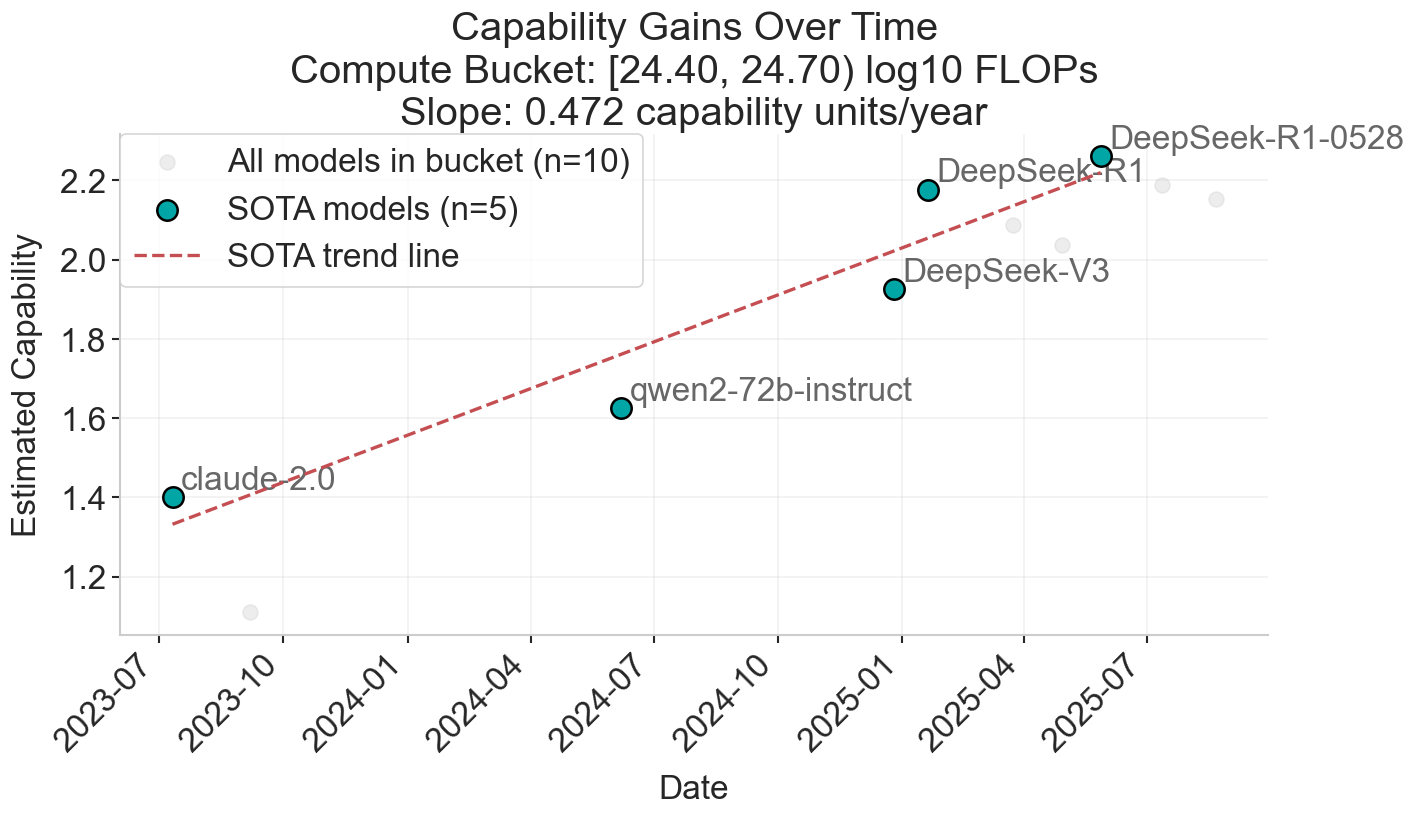


Compute Bucket: [24.40, 24.70) log10 FLOPs
Compute center: 3.55e+24 FLOPs
Total models: 10
SOTA models: 5
Date range: 2023-07-11 to 2025-05-28
Capability gain: 0.472 capability units/year
R²: 0.907
p-value: 1.236e-02


In [37]:
# ============================================================================
# Visual Plot: Capability vs Time for a Specific Compute Bucket
# ============================================================================

# SPECIFY WHICH BUCKET TO PLOT HERE:
# Options: use bucket indices from the summary table above, or specify range directly
selected_compute_lower_log10 = 24.4  # Change this to select different bucket (log10 FLOPs)
selected_compute_upper_log10 = 24.7  # Change this to select different bucket (log10 FLOPs)

import matplotlib.pyplot as plt
from scipy.stats import linregress

# Find models in the selected compute bucket
in_bucket = df_capability_sota[
    (df_capability_sota['log10_compute'] >= selected_compute_lower_log10) &
    (df_capability_sota['log10_compute'] < selected_compute_upper_log10)
].copy()

if len(in_bucket) < min_models_for_capability_fit:
    print(f"Not enough models in bucket [{selected_compute_lower_log10:.2f}, {selected_compute_upper_log10:.2f}) log10")
    print(f"Found {len(in_bucket)} models, need at least {min_models_for_capability_fit}")
else:
    # Sort by date and identify SOTA
    in_bucket = in_bucket.sort_values('date')
    in_bucket['cummax_capability'] = in_bucket['estimated_capability'].cummax()
    in_bucket['is_sota'] = in_bucket['estimated_capability'] >= in_bucket['cummax_capability']
    sota_models = in_bucket[in_bucket['is_sota']].copy()
    non_sota_models = in_bucket[~in_bucket['is_sota']].copy()
    
    if len(sota_models) < min_models_for_capability_fit:
        print(f"Not enough SOTA models in bucket [{selected_compute_lower_log10:.2f}, {selected_compute_upper_log10:.2f}) log10")
        print(f"Found {len(sota_models)} SOTA models, need at least {min_models_for_capability_fit}")
    else:
        # Compute regression on SOTA models
        sota_models['date_numeric'] = (
            (sota_models['date'] - sota_models['date'].min()).dt.total_seconds() / (365.25 * 24 * 3600)
        )
        
        slope, intercept, r_value, p_value, std_err = linregress(
            sota_models['date_numeric'],
            sota_models['estimated_capability']
        )
        
        # Create plot
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Plot all models in bucket (non-SOTA)
        if len(non_sota_models) > 0:
            ax.scatter(non_sota_models['date'], 
                      non_sota_models['estimated_capability'],
                      s=80, alpha=0.4, c='lightgray', 
                      label=f'All models in bucket (n={len(in_bucket)})',
                      zorder=1)
        
        # Plot SOTA models
        ax.scatter(sota_models['date'], 
                  sota_models['estimated_capability'],
                  s=150, marker='o', 
                  edgecolors='black', linewidth=1.5,
                  label=f'SOTA models (n={len(sota_models)})',
                  zorder=10)
        
        # Add model names for SOTA models
        for idx, row in sota_models.iterrows():
            model_name = row.get('model', row.get('model_name', 'Unknown'))
            ax.annotate(model_name, 
                       xy=(row['date'], row['estimated_capability']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=20, alpha=0.7)
        
        # Plot regression line
        date_range = pd.date_range(sota_models['date'].min(), sota_models['date'].max(), periods=100)
        date_range_numeric = (date_range - sota_models['date'].min()).total_seconds() / (365.25 * 24 * 3600)
        fit_line = intercept + slope * date_range_numeric
        ax.plot(date_range, fit_line, 'r--', linewidth=2, 
               label=f'SOTA trend line', zorder=5)
        
        # Formatting
        ax.set_xlabel('Date', fontsize=20)
        ax.set_ylabel('Estimated Capability', fontsize=20)
        
        bucket_center_log10 = (selected_compute_lower_log10 + selected_compute_upper_log10) / 2
        bucket_center_flops = 10**bucket_center_log10
        ax.set_title(
            f'Capability Gains Over Time\n'
            f'Compute Bucket: [{selected_compute_lower_log10:.2f}, {selected_compute_upper_log10:.2f}) log10 FLOPs\n'
            f'Slope: {slope:.3f} capability units/year',
            fontsize=24
        )
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=20)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        ax.tick_params(axis='both', labelsize=20)
        
        plt.tight_layout()
        plt.savefig(f'outputs/algorithmic_progress/capability_gain_fixed_compute.pdf', dpi=300)
        plt.savefig(f'outputs/algorithmic_progress/capability_gain_fixed_compute.svg', format="svg")
        plt.show()
        
        print(f"\nCompute Bucket: [{selected_compute_lower_log10:.2f}, {selected_compute_upper_log10:.2f}) log10 FLOPs")
        print(f"Compute center: {bucket_center_flops:.2e} FLOPs")
        print(f"Total models: {len(in_bucket)}")
        print(f"SOTA models: {len(sota_models)}")
        print(f"Date range: {sota_models['date'].min().strftime('%Y-%m-%d')} to {sota_models['date'].max().strftime('%Y-%m-%d')}")
        print(f"Capability gain: {slope:.3f} capability units/year")
        print(f"R²: {r_value**2:.3f}")
        print(f"p-value: {p_value:.3e}")


# Appendix C.3 Estimating algorithmic progress using ordinary least squares

In [26]:
# ============================================================================
# Joint OLS Model: capability = a * log10(compute) + b * (year - year_start)
# This fits both compute and time simultaneously to estimate algorithmic progress
# At fixed capability: d(log10(compute))/dt = -b/a
# Algorithmic progress (reduction magnitude) = |b/a| OOMs per year
# ============================================================================

print("=" * 70)
print("JOINT OLS APPROACH: Compute Reduction from Simultaneous Fit")
print("=" * 70)

# Prepare data
df_ols = df_cap_alt.copy()
df_ols = df_ols[df_ols['compute'].notna()].copy()
df_ols['date'] = pd.to_datetime(df_ols['date'])
df_ols = df_ols.sort_values('date')

# Create features
df_ols['log10_compute'] = np.log10(df_ols['compute'])
year_start = df_ols['date'].min().year
df_ols['years_since_start'] = (
    df_ols['date'].dt.year
    + df_ols['date'].dt.dayofyear / 365.25
    - year_start
)

print(f"\nDataset:")
print(f"  Models with compute data: {len(df_ols)}")
print(f"  Time range: {df_ols['date'].min().date()} to {df_ols['date'].max().date()}")
print(f"  Years span: {df_ols['years_since_start'].max():.2f} years")
print(f"  Compute range: [{df_ols['compute'].min():.2e}, {df_ols['compute'].max():.2e}] FLOPs")
print(f"  Capability range: [{df_ols['estimated_capability'].min():.3f}, {df_ols['estimated_capability'].max():.3f}]")

# Fit OLS model: capability ~ log10(compute) + years_since_start
X = df_ols[['log10_compute', 'years_since_start']].values
y = df_ols['estimated_capability'].values

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X_with_const).fit()

# Extract coefficients
intercept = model.params[0]
a = model.params[1]  # coefficient on log10(compute)
b = model.params[2]  # coefficient on years_since_start

# Signed derivative of log10(compute) w.r.t. time at fixed capability
# d(log10(compute))/dt = -b/a  (negative => compute falls over time)
dlog10c_dt = -b / a

# Magnitude of compute reduction rate at fixed capability (positive)
compute_reduction_ooms_per_year = abs(dlog10c_dt)

# Get confidence intervals for coefficients (still useful to inspect)
conf_int = model.conf_int(alpha=0.05)   # 95% CI
conf_int_90 = model.conf_int(alpha=0.10)  # 90% CI

# Calculate CI for compute reduction rate using (approximate) delta method
# For ratio b/a, Var(b/a) ≈ (b/a)^2 * (Var(b)/b^2 + Var(a)/a^2)
se_a = model.bse[1]
se_b = model.bse[2]

# Approximate standard error for |b/a|
ratio = b / a
se_ratio = abs(ratio) * np.sqrt((se_b / b) ** 2 + (se_a / a) ** 2)

# 95% CI for the magnitude
ci_95_lower = compute_reduction_ooms_per_year - 1.96 * se_ratio
ci_95_upper = compute_reduction_ooms_per_year + 1.96 * se_ratio

# 90% CI for the magnitude
ci_90_lower = compute_reduction_ooms_per_year - 1.645 * se_ratio
ci_90_upper = compute_reduction_ooms_per_year + 1.645 * se_ratio

# Derived interpretive quantities
factor_reduction_per_year = 10 ** compute_reduction_ooms_per_year
doubling_time_years = np.log10(2) / compute_reduction_ooms_per_year  # 2× less compute

print(f"\n{'='*70}")
print(f"OLS MODEL RESULTS")
print(f"{'='*70}")
print(
    "Model: capability = "
    f"{intercept:.4f} + {a:.4f} * log10(compute) + {b:.4f} * years_since_start"
)
print(f"\nCoefficients:")
print(f"  Intercept: {intercept:.4f}")
print(f"  a (log10 compute): {a:.4f} (SE: {se_a:.4f}, p: {model.pvalues[1]:.4e})")
print(f"  b (years_since_start): {b:.4f} (SE: {se_b:.4f}, p: {model.pvalues[2]:.4e})")
print(f"\nModel fit:")
print(f"  R-squared: {model.rsquared:.4f}")
print(f"  Adjusted R-squared: {model.rsquared_adj:.4f}")
print(f"  F-statistic: {model.fvalue:.2f} (p: {model.f_pvalue:.4e})")
print(f"  AIC: {model.aic:.2f}")
print(f"  BIC: {model.bic:.2f}")

print(f"\n{'='*70}")
print(f"ALGORITHMIC PROGRESS (Compute Reduction at Fixed Capability)")
print(f"{'='*70}")
print(
    f"Signed derivative d log10(compute) / dt: "
    f"{dlog10c_dt:.3f} OOMs/year (negative ⇒ compute falls over time)"
)
print(f"Reduction magnitude: {compute_reduction_ooms_per_year:.3f} OOMs/year")
print(f"95% CI (magnitude): [{ci_95_lower:.3f}, {ci_95_upper:.3f}] OOMs/year")
print(f"90% CI (magnitude): [{ci_90_lower:.3f}, {ci_90_upper:.3f}] OOMs/year")
print(f"\nInterpretation:")
print(
    f"  To achieve the same capability level, compute requirements decrease by "
    f"{compute_reduction_ooms_per_year:.3f} orders of magnitude per year."
)
print(
    f"  This means a {factor_reduction_per_year:.2f}× reduction in compute per year."
)
print(
    f"  Doubling time (2× less compute): {doubling_time_years:.2f} years"
)

# Calculate residuals and diagnostics
df_ols['predicted_capability'] = model.predict(X_with_const)
df_ols['residual'] = df_ols['estimated_capability'] - df_ols['predicted_capability']

print(f"\nResidual diagnostics:")
print(f"  Mean residual: {df_ols['residual'].mean():.4f}")
print(f"  Std residual: {df_ols['residual'].std():.4f}")
print(f"  Max absolute residual: {df_ols['residual'].abs().max():.4f}")


JOINT OLS APPROACH: Compute Reduction from Simultaneous Fit

Dataset:
  Models with compute data: 68
  Time range: 2023-02-24 to 2025-09-24
  Years span: 2.73 years
  Compute range: [1.56e+22, 5.00e+26] FLOPs
  Capability range: [0.213, 2.645]

OLS MODEL RESULTS
Model: capability = -6.6235 + 0.3107 * log10(compute) + 0.3747 * years_since_start

Coefficients:
  Intercept: -6.6235
  a (log10 compute): 0.3107 (SE: 0.0312, p: 1.0303e-14)
  b (years_since_start): 0.3747 (SE: 0.0448, p: 6.4257e-12)

Model fit:
  R-squared: 0.8974
  Adjusted R-squared: 0.8942
  F-statistic: 284.27 (p: 7.2769e-33)
  AIC: -24.57
  BIC: -17.91

ALGORITHMIC PROGRESS (Compute Reduction at Fixed Capability)
Signed derivative d log10(compute) / dt: -1.206 OOMs/year (negative ⇒ compute falls over time)
Reduction magnitude: 1.206 OOMs/year
95% CI (magnitude): [0.837, 1.575] OOMs/year
90% CI (magnitude): [0.896, 1.516] OOMs/year

Interpretation:
  To achieve the same capability level, compute requirements decrease by 1